# How green infracstructure affects local temperature in NYC

## Install missing libraries (if any)

In [1]:
!pip install --upgrade fsspec
!pip install --upgrade tensorflow
!pip install --upgrade pydot

  Using cached tensorflow-2.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached optree-

## Load data

### Access configuration

open a terminal and execute `aws configure --profile eaeee4000` interactively entering the credential information as follows:
```
AWS Access Key ID [None]: LLXG1H840JLTXMV6G430
AWS Secret Access Key [None]:  40SuRAhZQry2lL0AkUSLH16APw0MkGJB7BnNXp5v
Default region name [None]: 
Default output format [None]:
```

In [2]:
ENDPOINT           = 'https://nyu1.osn.mghpcc.org'
EAEEE4000_PROFILE  = 'eaeee4000'
LEAPBUCKET         = 'leap-edu-test'
NYC4URBAN_ZARR_DIR = 'nyc4urban/nyc4urban.zarr'

### Connect to cloud storage

In [3]:
import fsspec, os

fs = fsspec.filesystem(
    's3',
    anon          = False,
    profile       = EAEEE4000_PROFILE,
    client_kwargs = {'endpoint_url': ENDPOINT}
)
fs_mapper = fs.get_mapper(
    os.path.join(LEAPBUCKET, NYC4URBAN_ZARR_DIR)
)

fs.ls('leap-edu-test/nyc4urban/')

['leap-edu-test/nyc4urban/NYC4Urban_v1-20240628.zip',
 'leap-edu-test/nyc4urban/nyc4urban.zarr']

### Load NYC4Urban dataset from cloud

In [4]:
import xarray as xr
xar = xr.open_dataset(fs_mapper, engine='zarr', chunks={}).to_array()
xar = xar[0,...]
xar

<xarray.DataArray (loc: 30537, layer: 29, n: 288, m: 288)> Size: 147GB
dask.array<getitem, shape=(30537, 29, 288, 288), dtype=int16, chunksize=(10, 29, 288, 288), chunktype=numpy.ndarray>
Coordinates:
  * loc       (loc) int64 244kB 0 1 2 3 4 5 6 7 8 ... 9 10 11 12 13 14 15 16 17
    variable  <U9 36B 'NYC4Urban'
Dimensions without coordinates: layer, n, m

![image.png](Urban4NYC_layers.png)

## Preprocess data

### Data Overview

In [5]:
import numpy as np
import pandas as pd

data_size = 3000

red_17 = xar[:data_size, 0, :, :]
green_17 = xar[:data_size, 2, :, :]
blue_17 = xar[:data_size, 4, :, :]
infrared_17 = xar[:data_size, 6, :, :]

landcover = xar[:data_size, 28, :, :]
landcover = landcover - 1

#thermal_data = xar[:1000, 22:27, :, :]  # Thermal Data (Layer 23-27)
#thermal_data = np.stack([thermal_data[:, i, :, :] for i in range(5)], axis=-1)

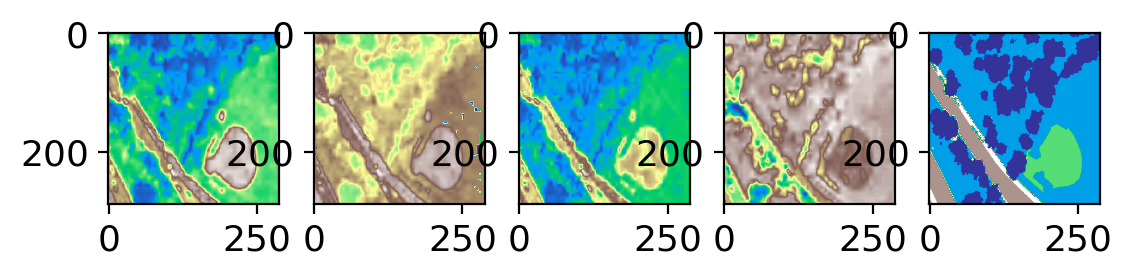

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

fig, ax = plt.subplots(1,5)

location = 0

ax[0].imshow(red_17[location].T, cmap='terrain')
ax[1].imshow(green_17[location].T, cmap='terrain')
ax[2].imshow(blue_17[location].T, cmap='terrain')
ax[3].imshow(infrared_17[location].T, cmap='terrain')
ax[4].imshow(landcover[location].T, cmap='terrain')

plt.show()

In [7]:
np.unique(landcover.to_numpy(), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int16),
 array([34376588, 53006904,  6897722, 27046093, 39497563, 30924590,
        54712273,  2370267]))

### Data preprocessing

In [8]:
def normalize(data, no_data_value=-128):
    data = np.where(data == no_data_value, np.nan, data)  # 处理 No-Data 值
    data = np.nan_to_num(data, nan=0)  # 将 NaN 转换为 0
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [9]:
red_17 = normalize(red_17)
green_17 = normalize(green_17)
blue_17 = normalize(blue_17)
infrared_17 = normalize(infrared_17)

In [10]:
spectral_17 = np.stack([red_17, green_17, blue_17, infrared_17], axis=-1)

In [11]:
from keras.utils import to_categorical

landcover_encoded = to_categorical(landcover, num_classes=8)

2024-12-04 02:58:41.069794: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 02:58:41.071179: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 02:58:41.074270: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 02:58:41.082079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733281121.095011    1007 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733281121.09

In [12]:
landcover_encoded.shape

(3000, 288, 288, 8)

In [13]:
train_size = int(0.8 * spectral_17.shape[0])
X_train, X_test = spectral_17[:train_size], spectral_17[train_size:]
y_train, y_test = landcover_encoded[:train_size], landcover_encoded[train_size:]

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 288, 288, 4),
 (600, 288, 288, 4),
 (2400, 288, 288, 8),
 (600, 288, 288, 8))

## Train model

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.regularizers import l1_l2
from utils import *
from keras.utils import plot_model
import pydot

In [16]:
# Input Layer
input_shape = (288, 288, 4)  # (Height, Width, Channels)
inputs = Input(shape=input_shape)

# Encoder
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

# Decoder
u5 = UpSampling2D((2, 2))(c4)
u5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
u5 = concatenate([u5, c3])  # Skip connection
u5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)

u6 = UpSampling2D((2, 2))(u5)
u6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
u6 = concatenate([u6, c2])  # Skip connection
u6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)

u7 = UpSampling2D((2, 2))(u6)
u7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
u7 = concatenate([u7, c1])  # Skip connection
u7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)

# Output Layer
outputs = Conv2D(8, (1, 1), activation='softmax')(u7)

# Model
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2024-12-04 02:59:01.036729: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 288,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 288, 288,  │      1,184 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 288, 288,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 144, 144,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 144, 144,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 144, 144,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 72, 72,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 72, 72,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 72, 72,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 36, 36,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 36, 36,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 36, 36,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 72, 72,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 72, 72,    │    295,040 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72, 72,    │          0 │ conv2d_8[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 72, 72,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 144, 144,  │          0 │ conv2d_9[0][0]  

 Total params: 1,947,400 (7.43 MB)

 Trainable params: 1,947,400 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

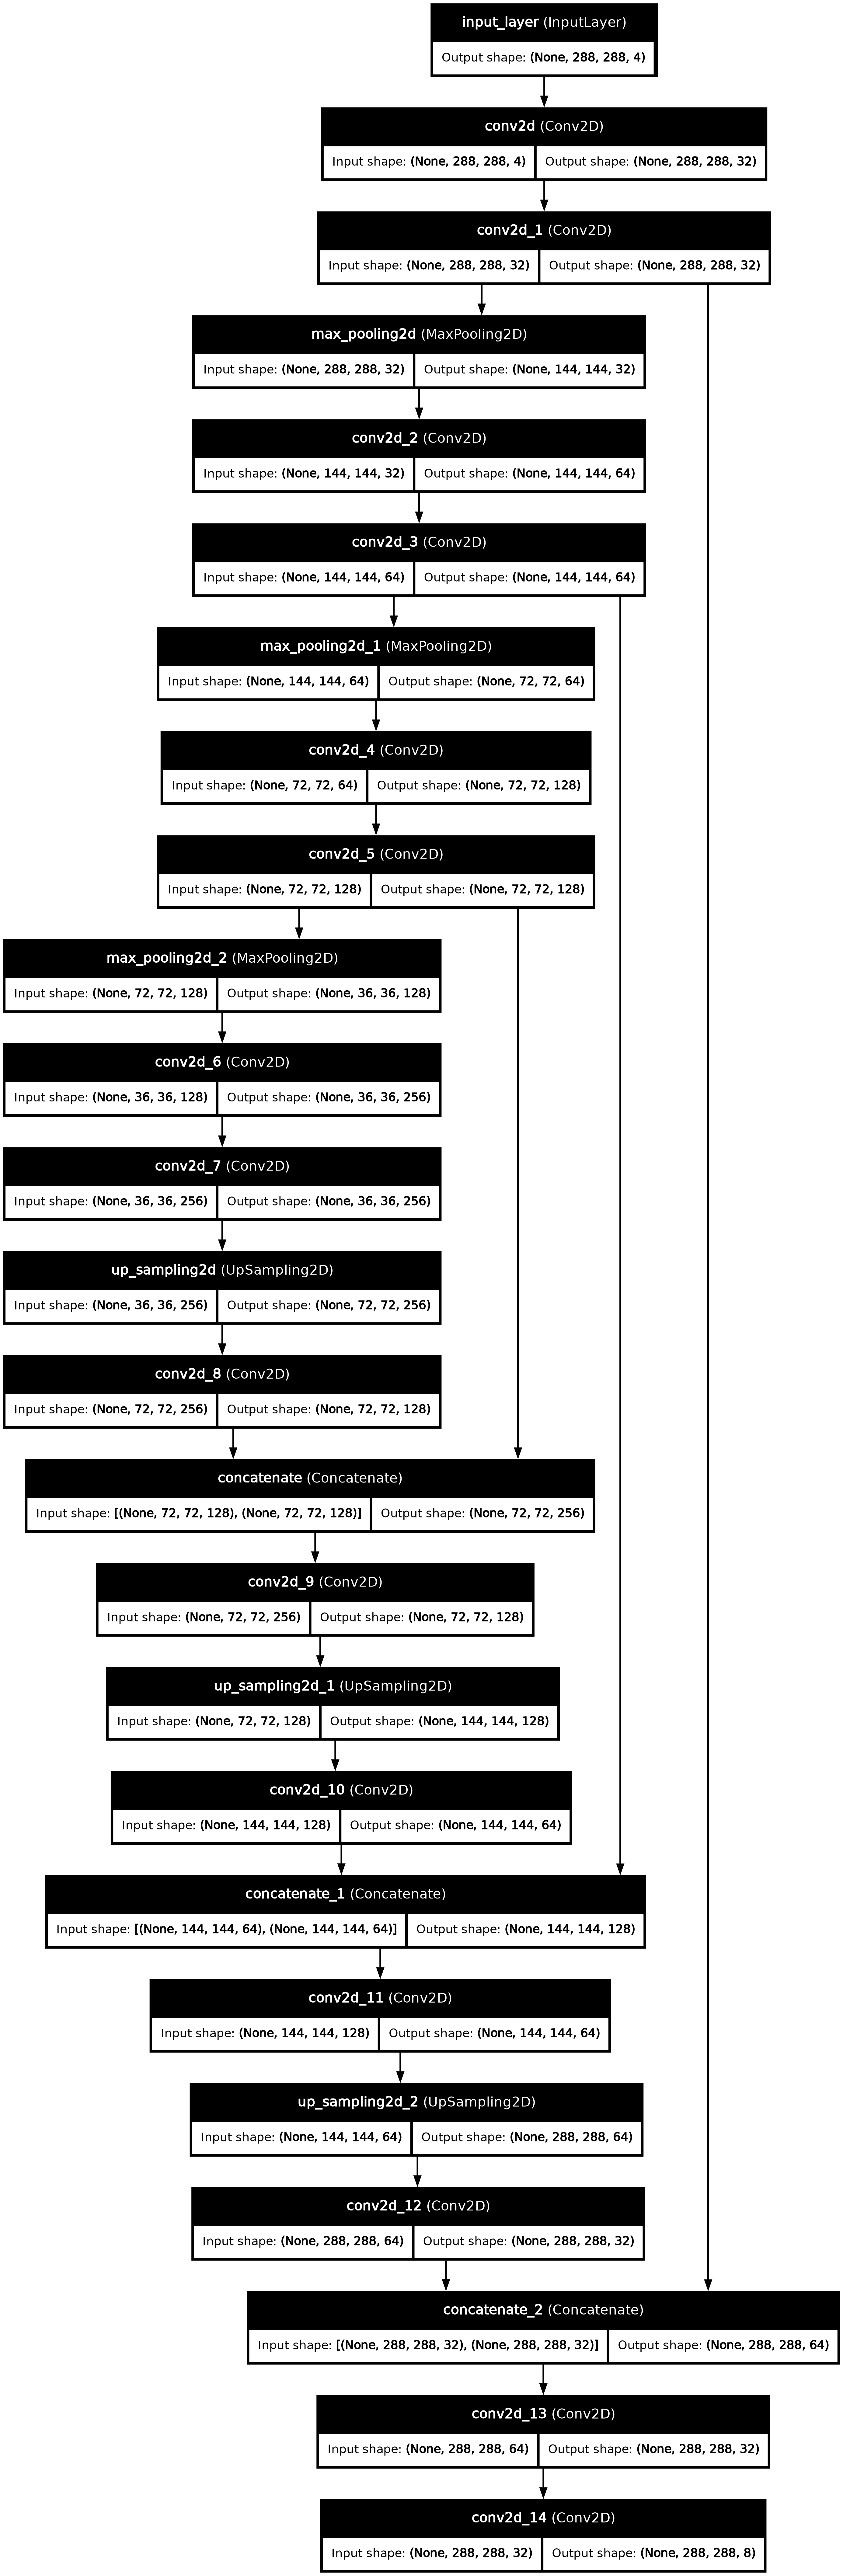

In [17]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [18]:
#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=18, batch_size=16, validation_split=0.2)

y_pred = model.predict(X_test).reshape(-1, landcover_encoded.shape[1], landcover_encoded.shape[2], landcover_encoded.shape[3])
y_pred_classes = np.argmax(y_pred, axis=-1)

y_test_classes = np.argmax(y_test, axis=-1)

Epoch 1/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3086 - loss: 1.7032 - val_accuracy: 0.5727 - val_loss: 1.0632
Epoch 2/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.4673 - loss: 1.2731 - val_accuracy: 0.5783 - val_loss: 1.0441
Epoch 3/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4976 - loss: 1.2295 - val_accuracy: 0.6112 - val_loss: 1.0123
Epoch 4/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5313 - loss: 1.1738 - val_accuracy: 0.6561 - val_loss: 0.9861
Epoch 5/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5870 - loss: 1.0811 - val_accuracy: 0.6688 - val_loss: 0.8884
Epoch 6/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.6044 - loss: 1.0199 - val_accuracy: 0.6900 - val_loss: 0.8260
Epoch 7/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.6306 - loss: 0.9632 - val_accuracy: 0.7056 - val_loss: 0.8040
Epoch 8/18
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6623 - loss: 0.8934 - val_accu

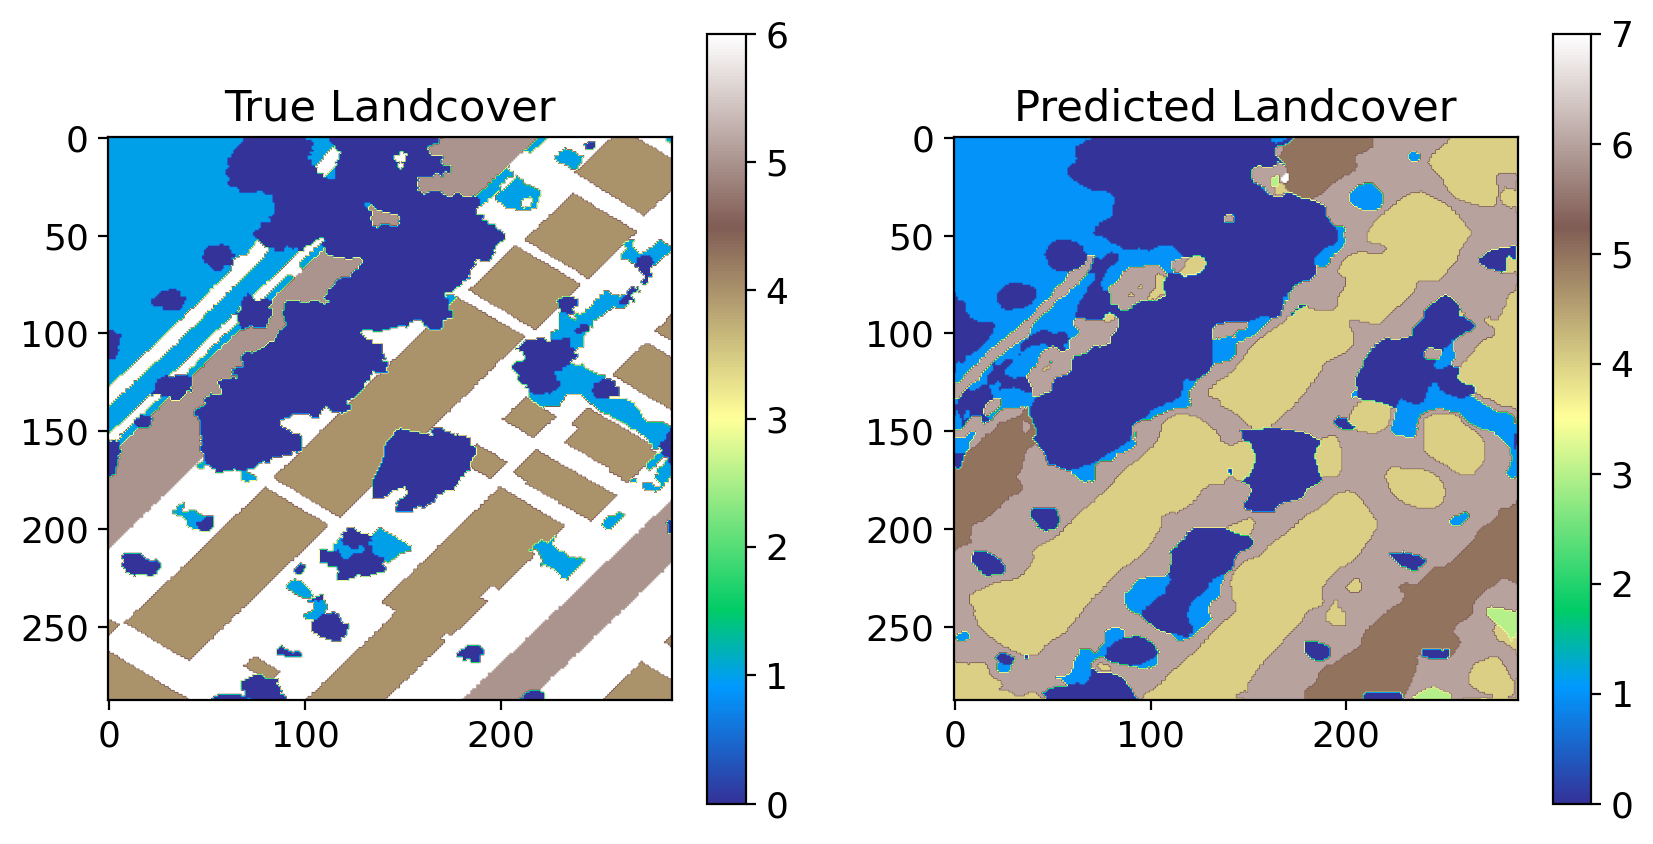

In [19]:

sample_idx = 19
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("True Landcover")
plt.imshow(y_test_classes[sample_idx, :, :], cmap='terrain')  
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Predicted Landcover")
plt.imshow(y_pred_classes[sample_idx, :, :], cmap='terrain')  
plt.colorbar()

plt.show()

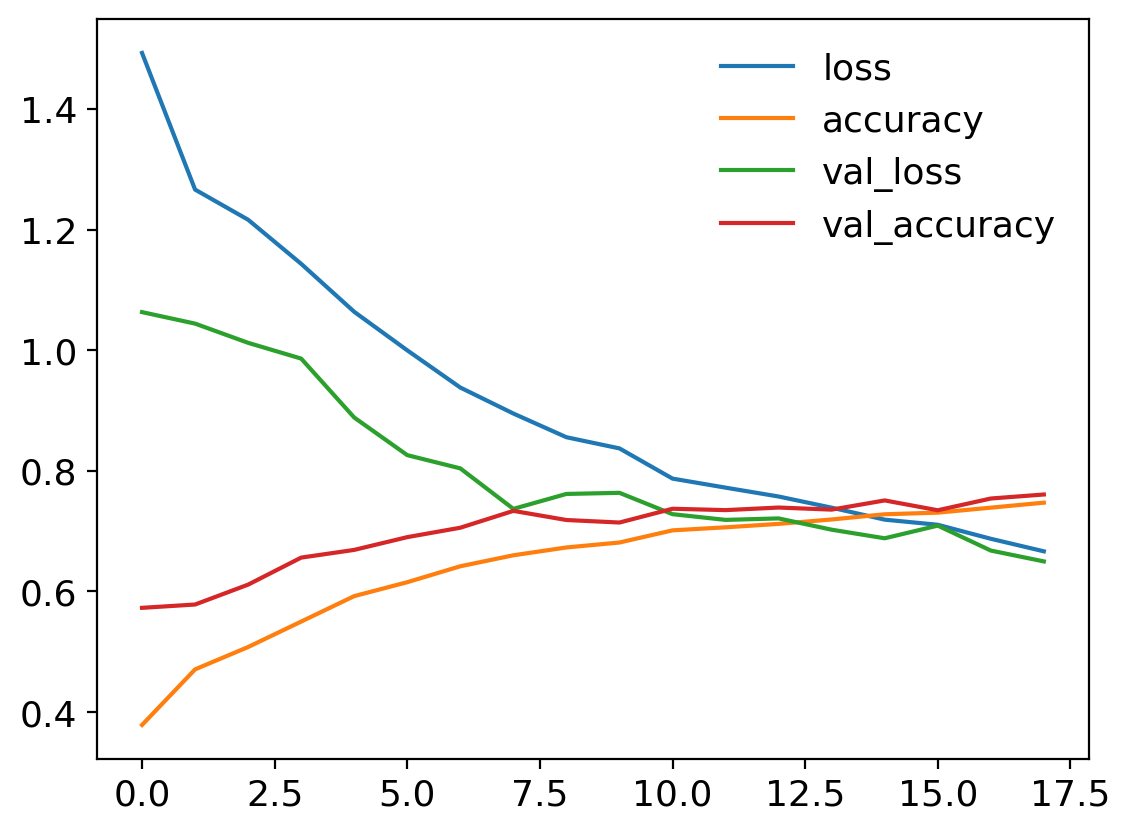

In [20]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['accuracy'], label = 'accuracy')
ax.plot(history.history['val_loss'], label = 'val_loss')
ax.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.legend()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score

# Predict classes for the test set
y_pred = model.predict(X_test).reshape(-1, landcover_encoded.shape[1], landcover_encoded.shape[2], landcover_encoded.shape[3])
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert predictions to class indices

# Convert ground truth labels to class indices
y_test_classes = np.argmax(y_test, axis=-1)

# Flatten arrays for comparison (pixel-level accuracy)
y_pred_flat = y_pred_classes.flatten()
y_test_flat = y_test_classes.flatten()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_flat, y_pred_flat)

print(f"Test Set Accuracy: {test_accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 807ms/step
Test Set Accuracy: 0.7067


### Feature Map

/srv/conda/envs/notebook/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 288, 288, 4))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


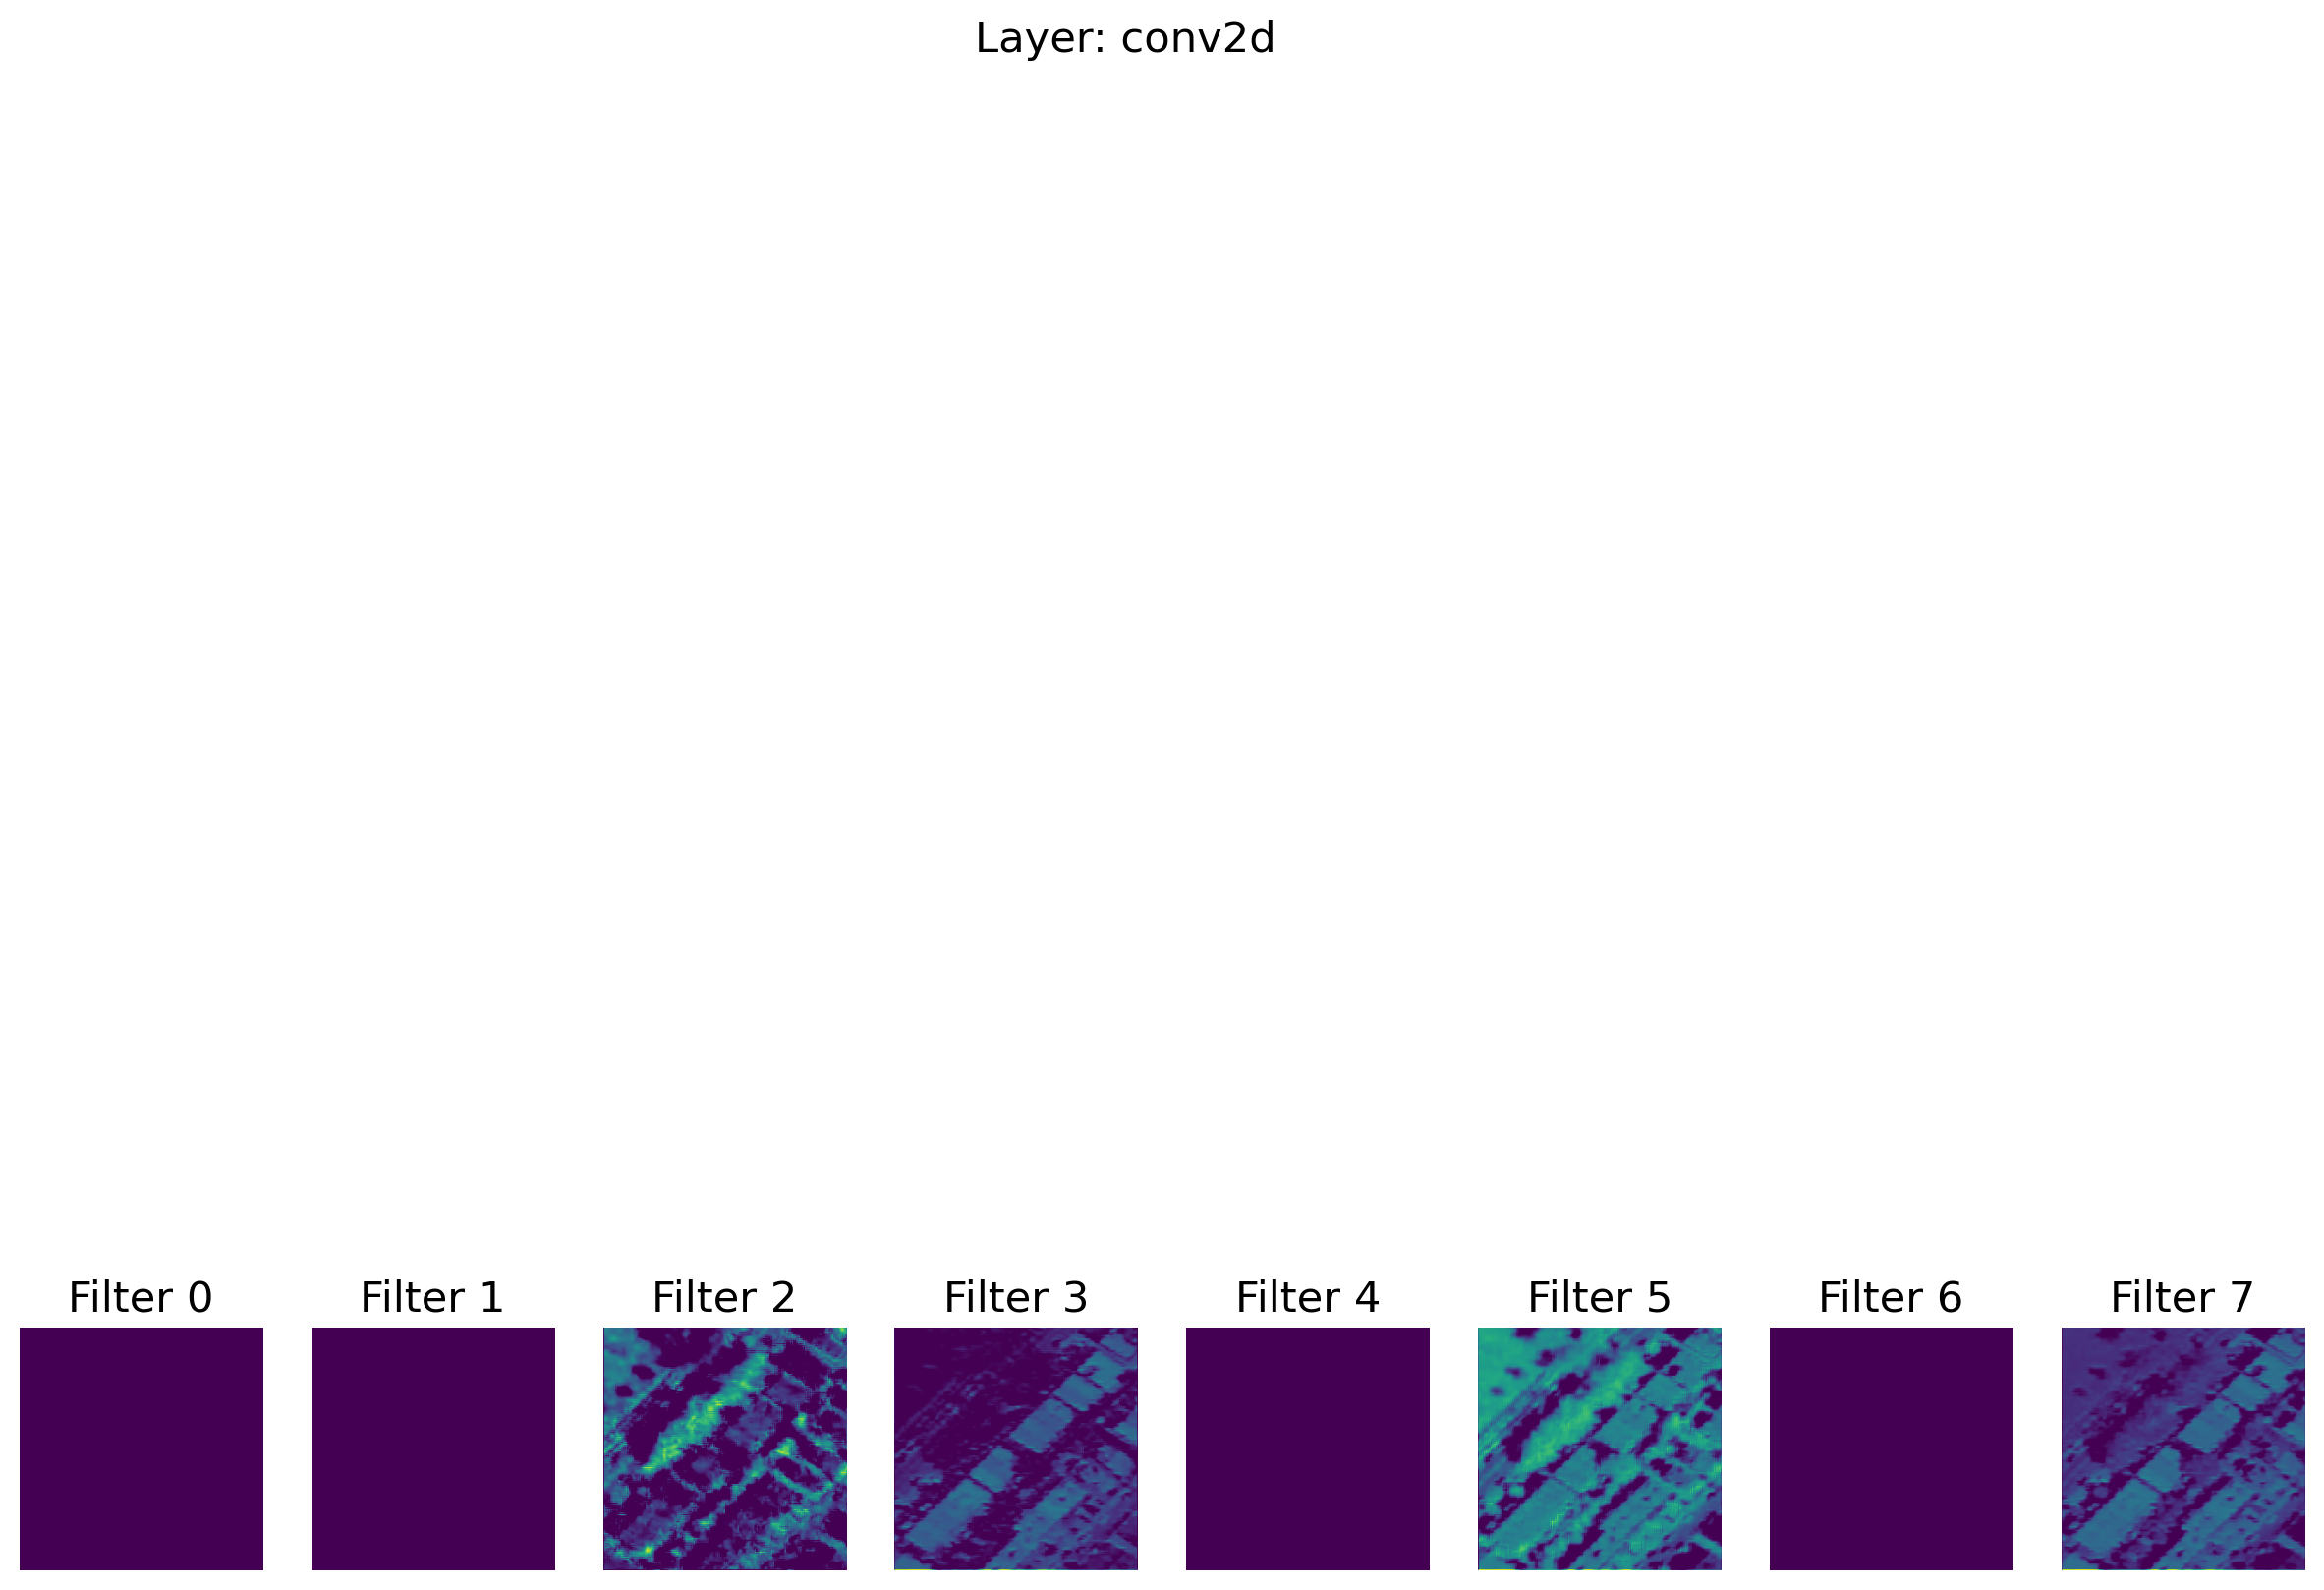

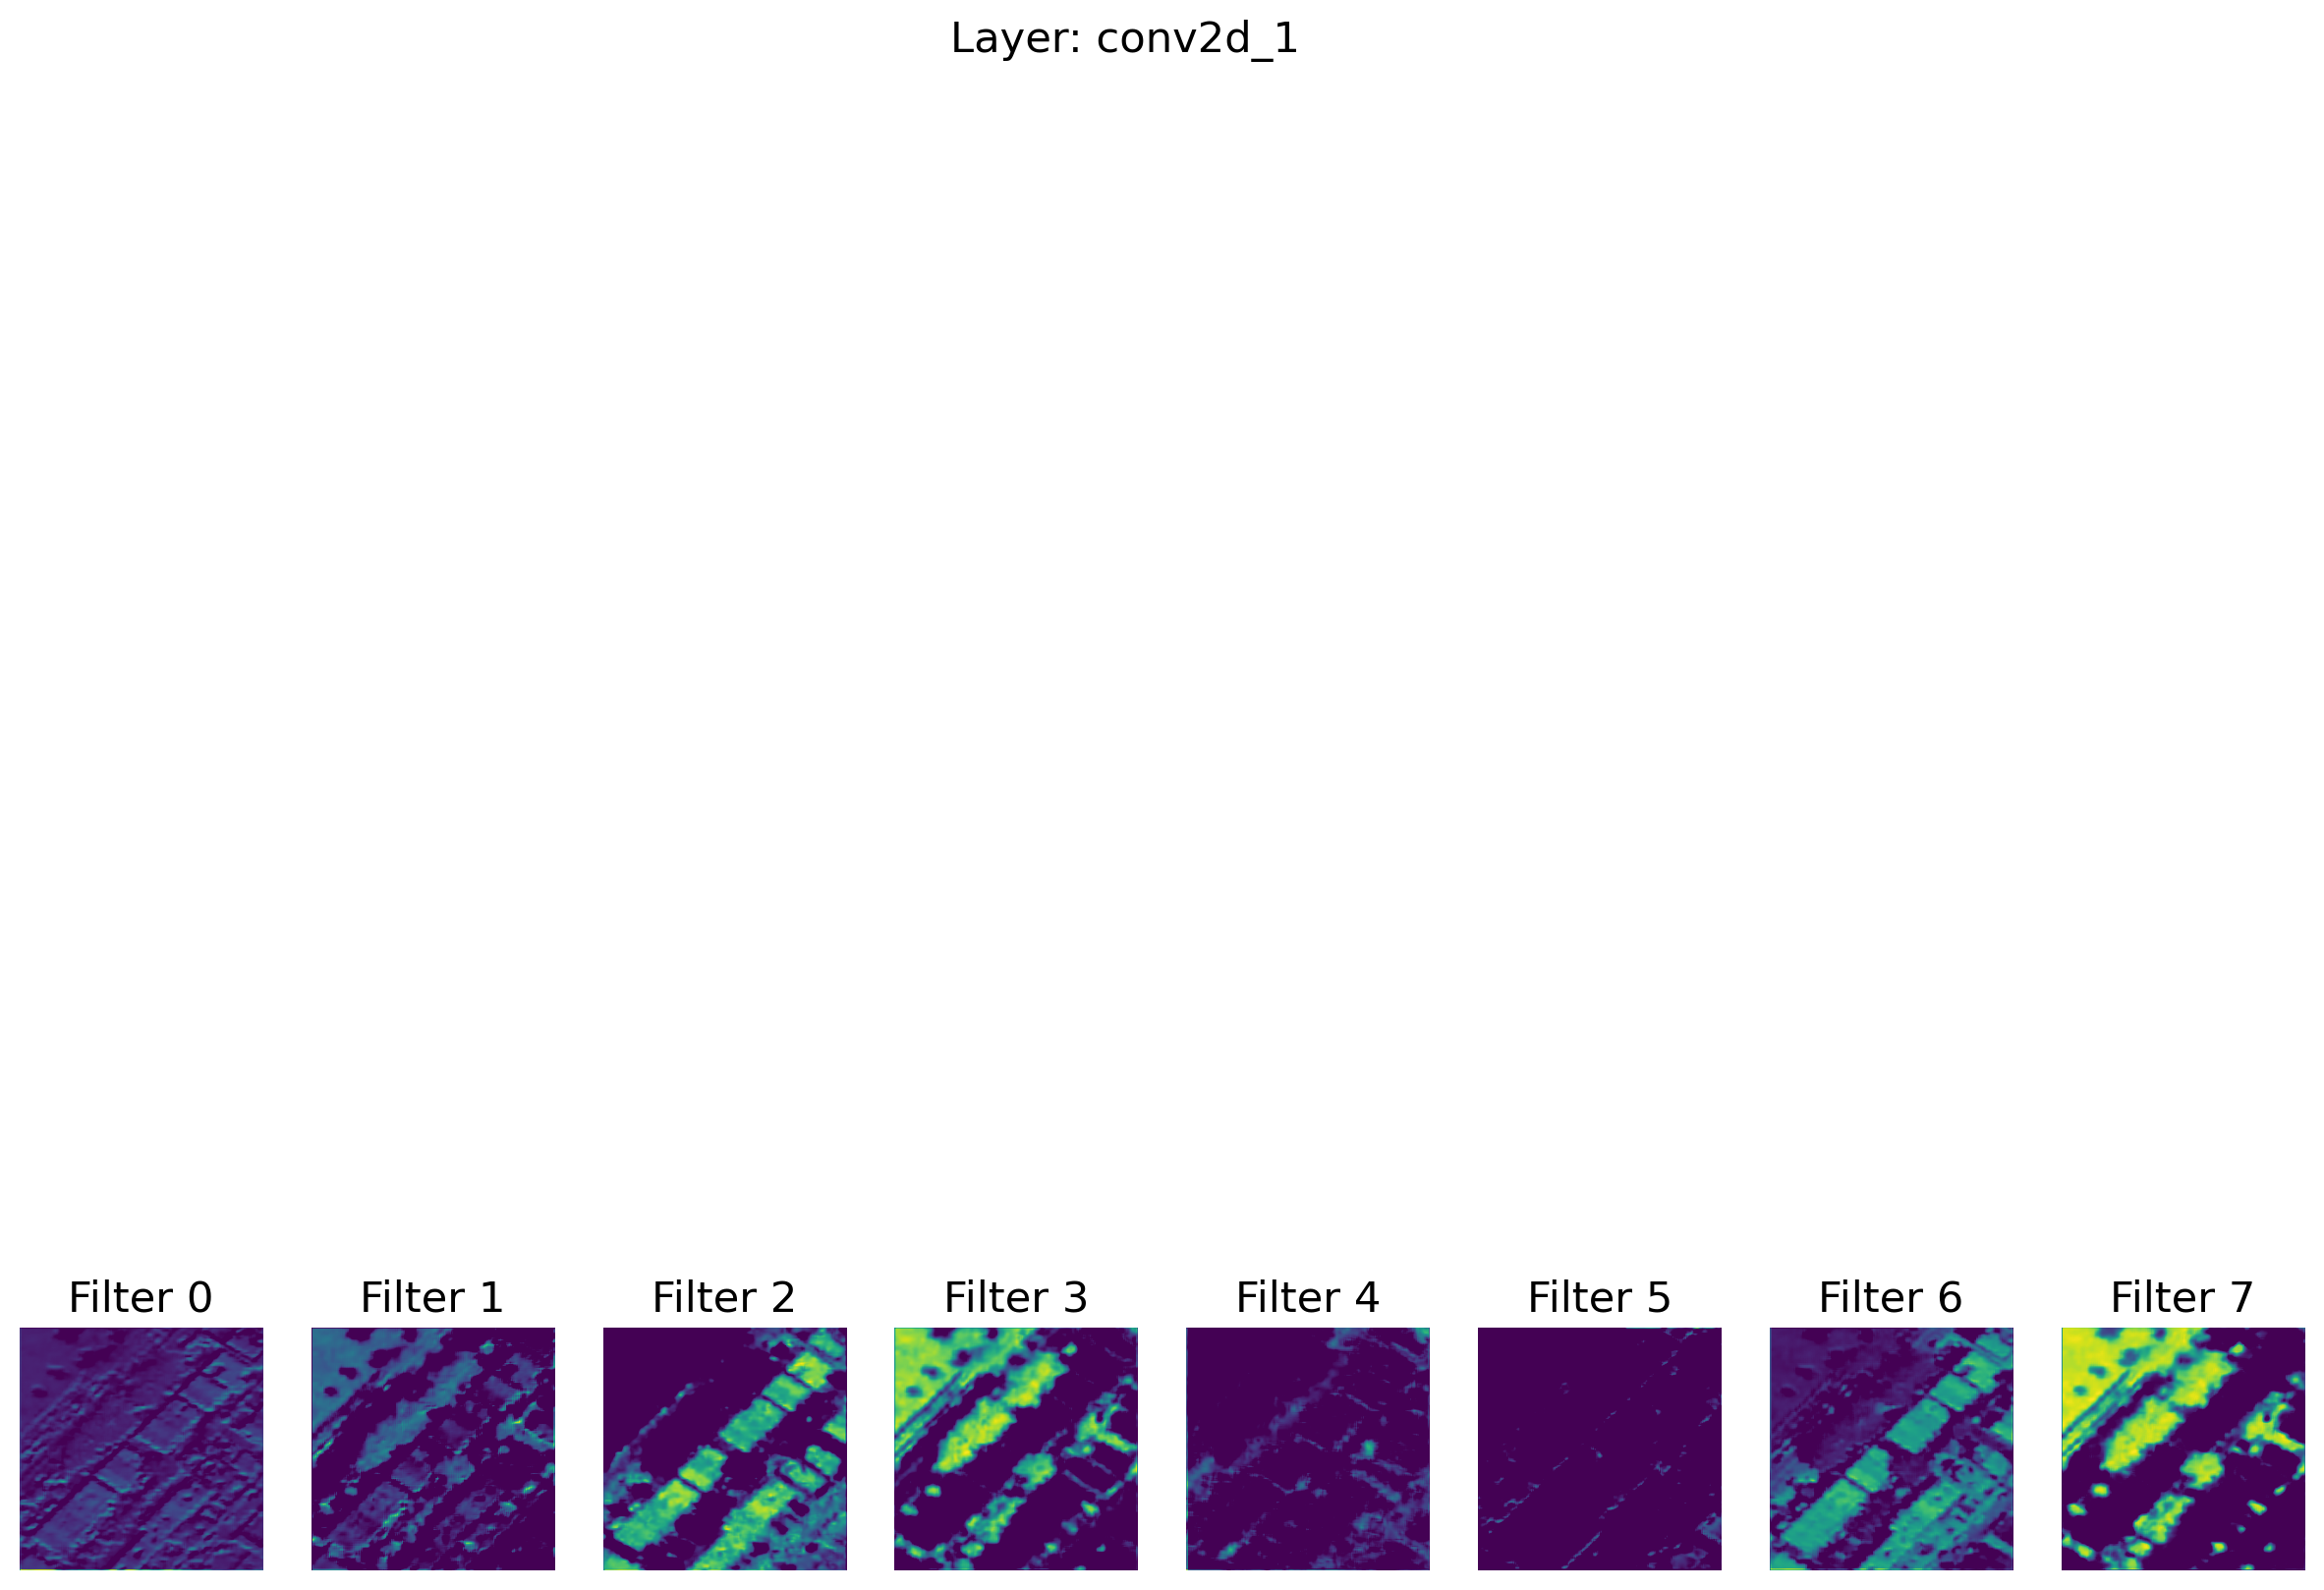

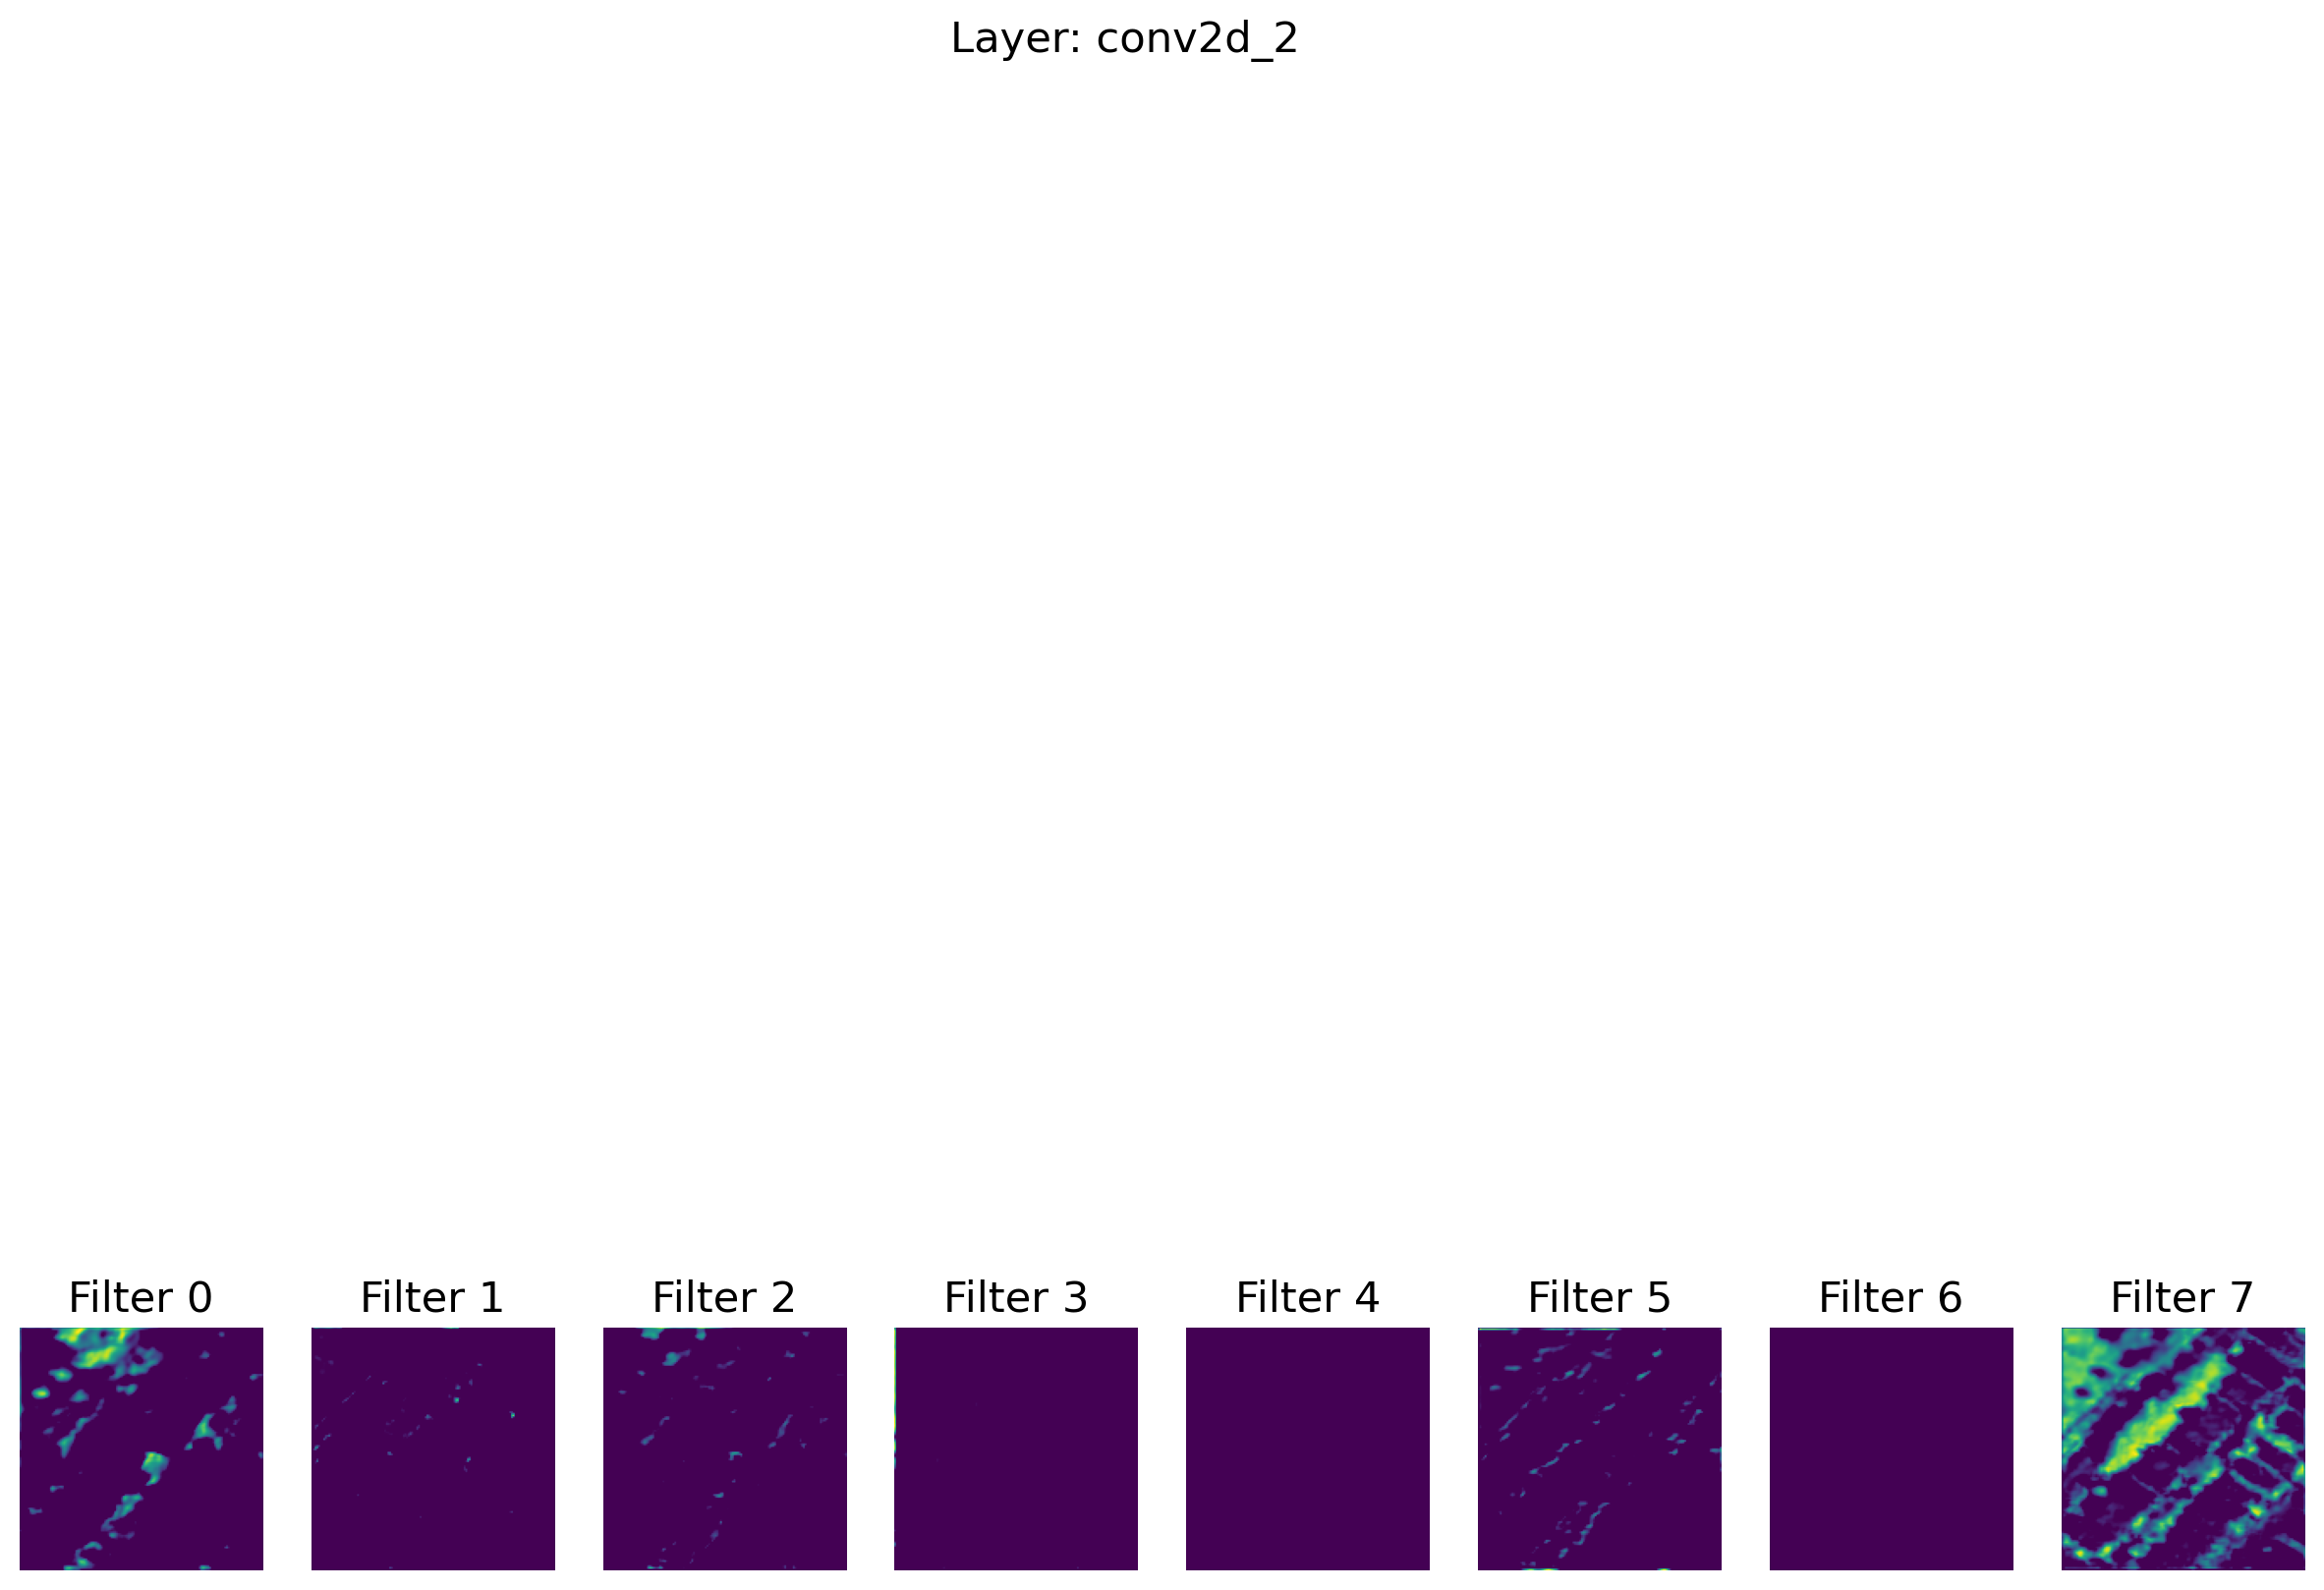

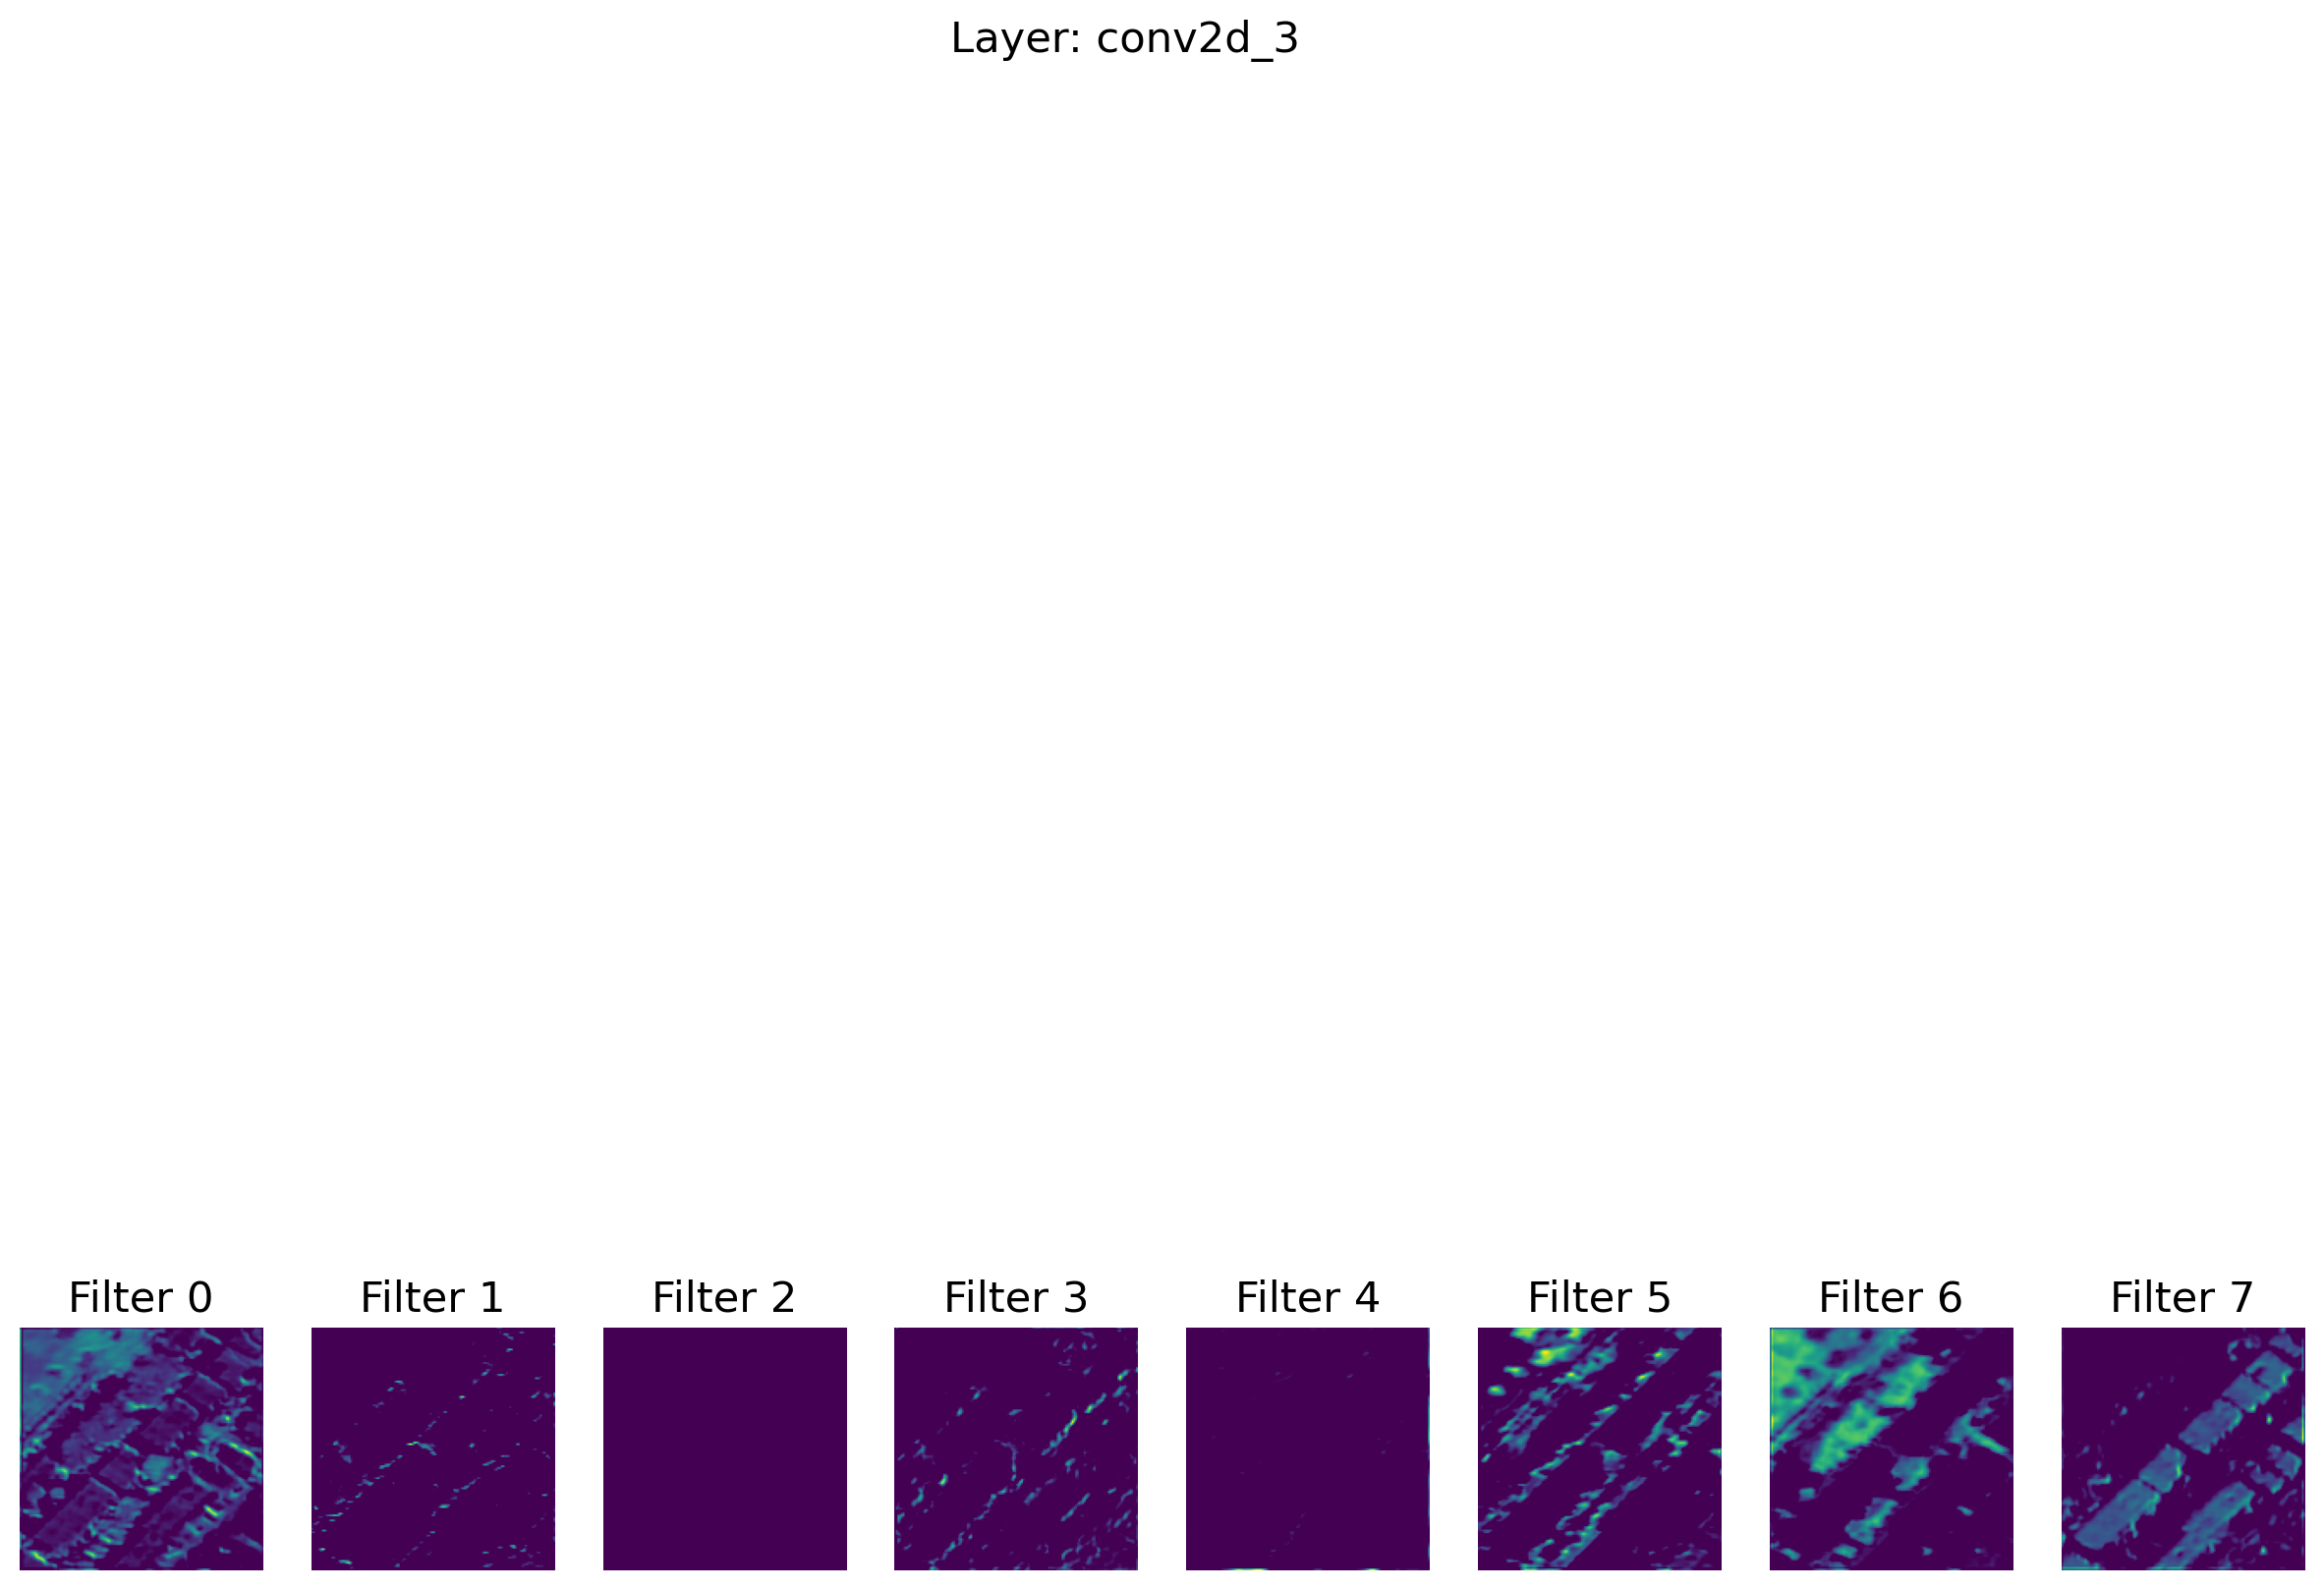

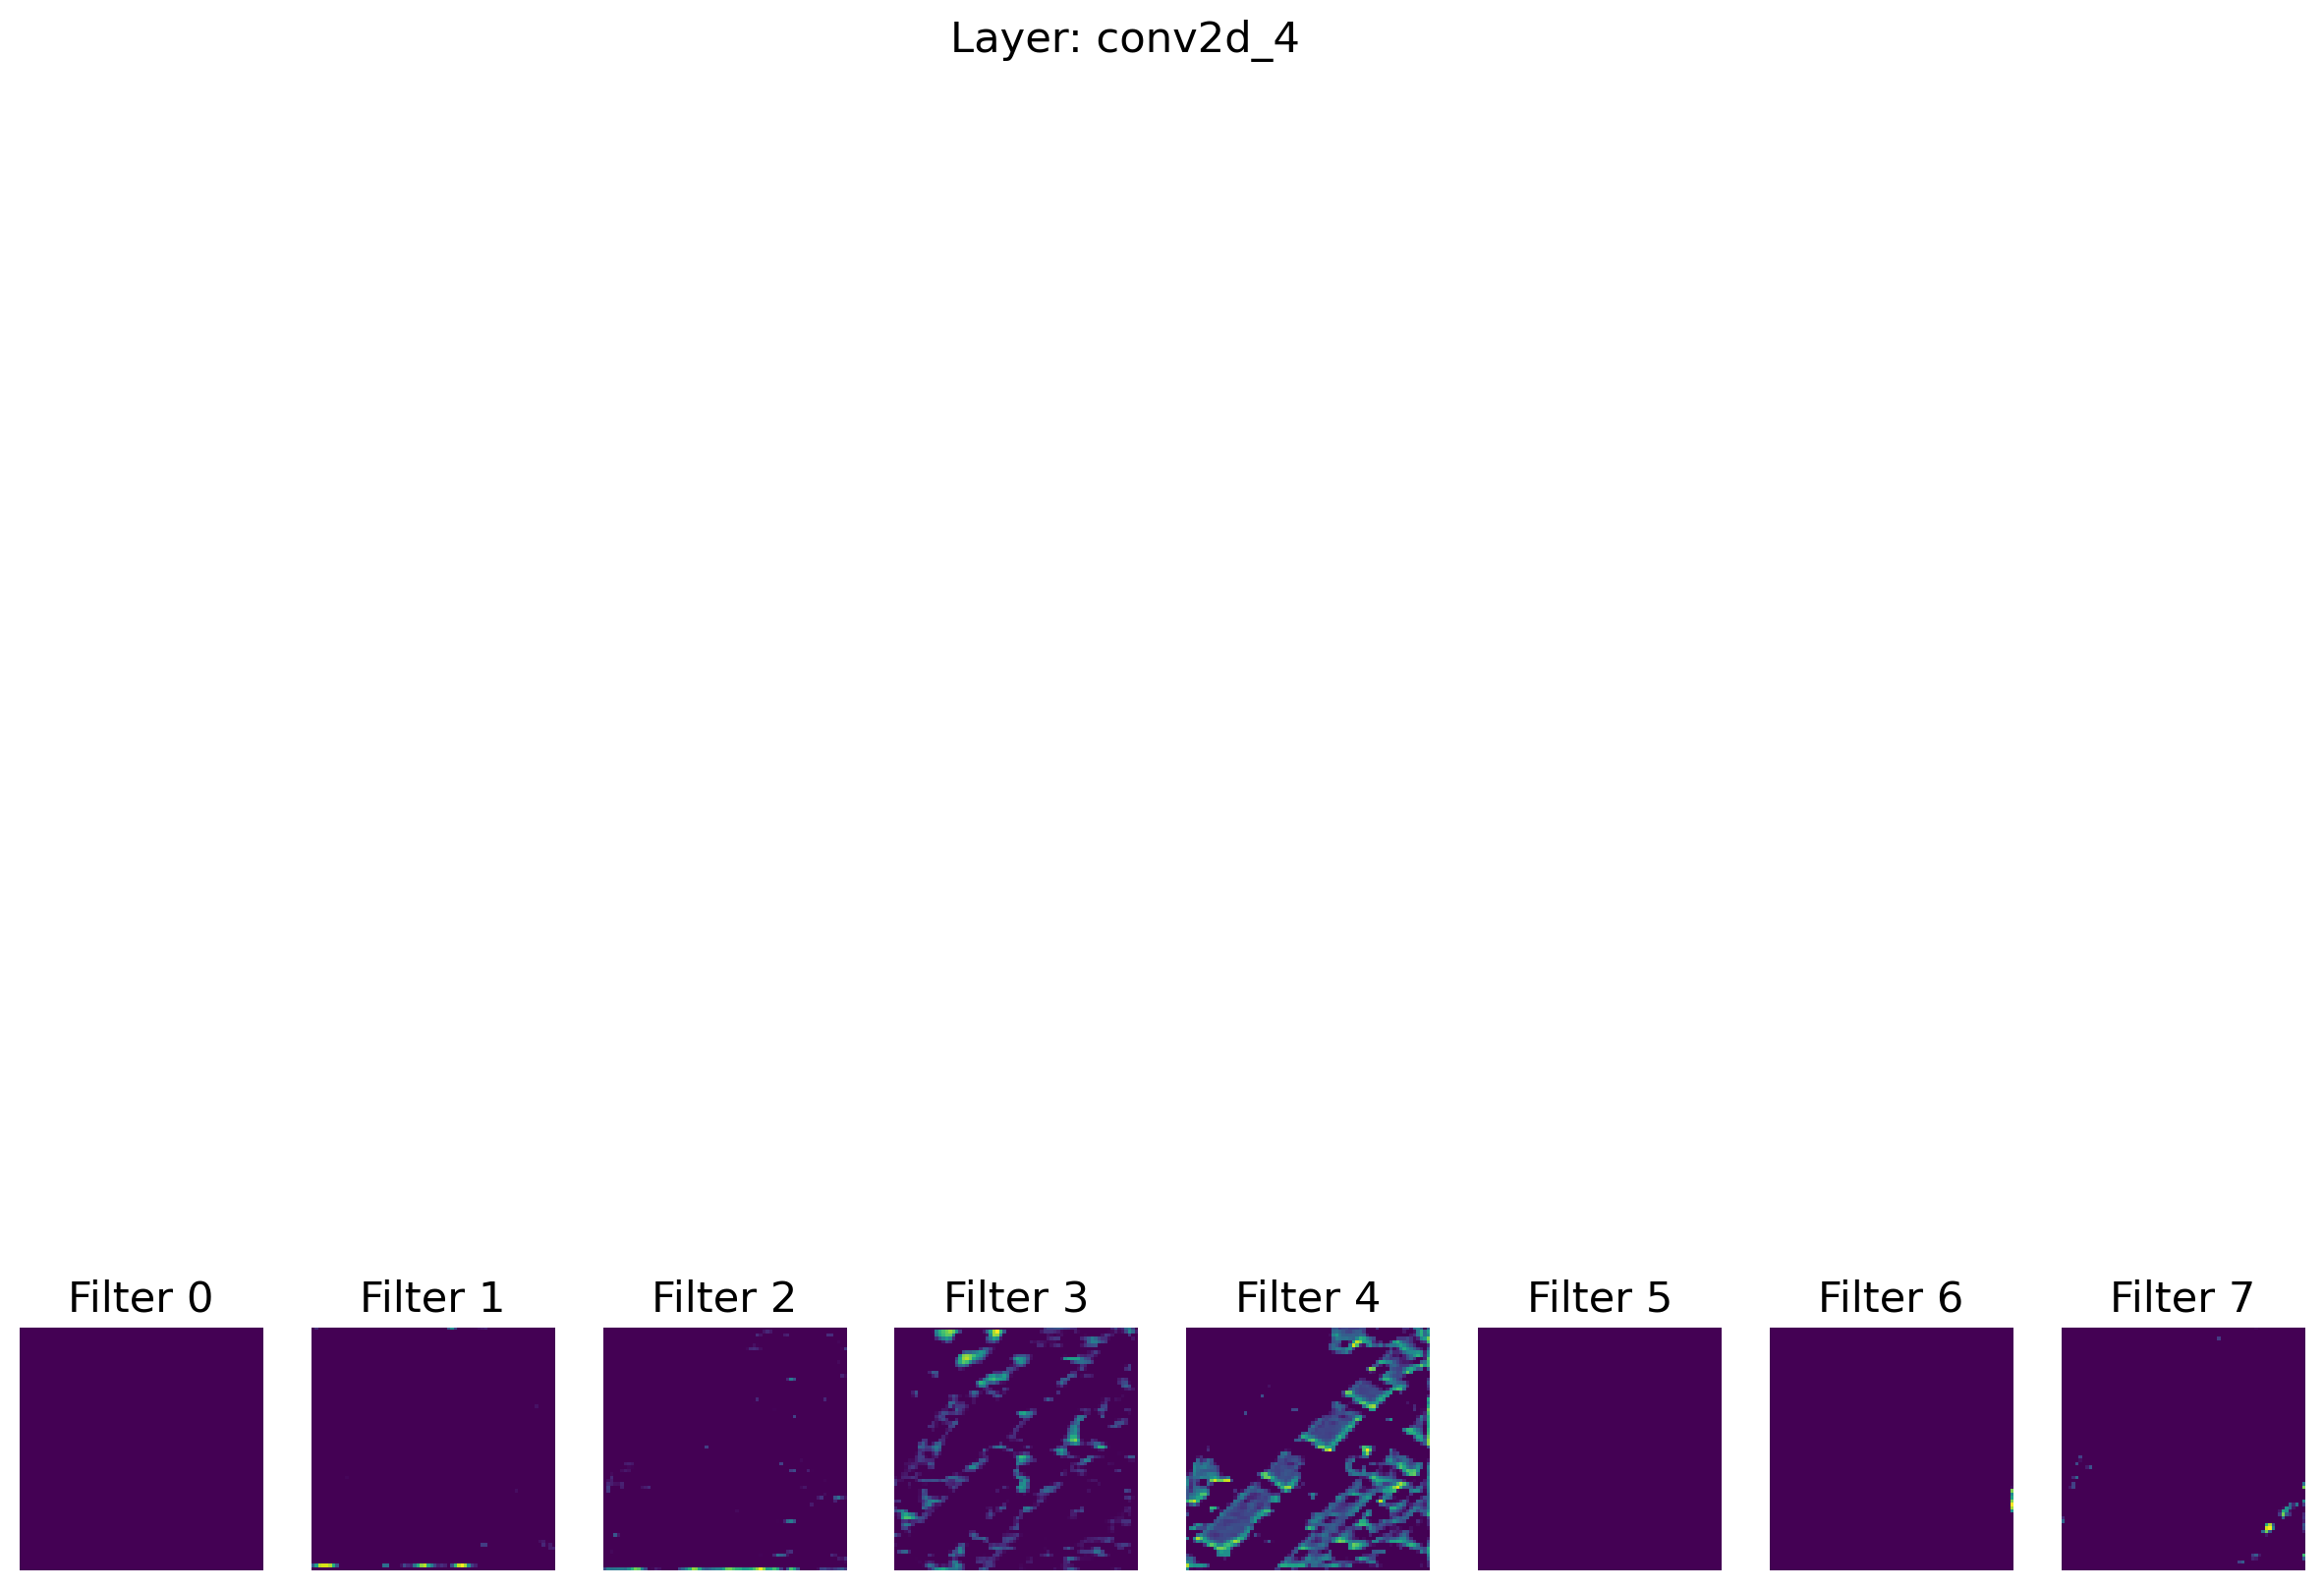

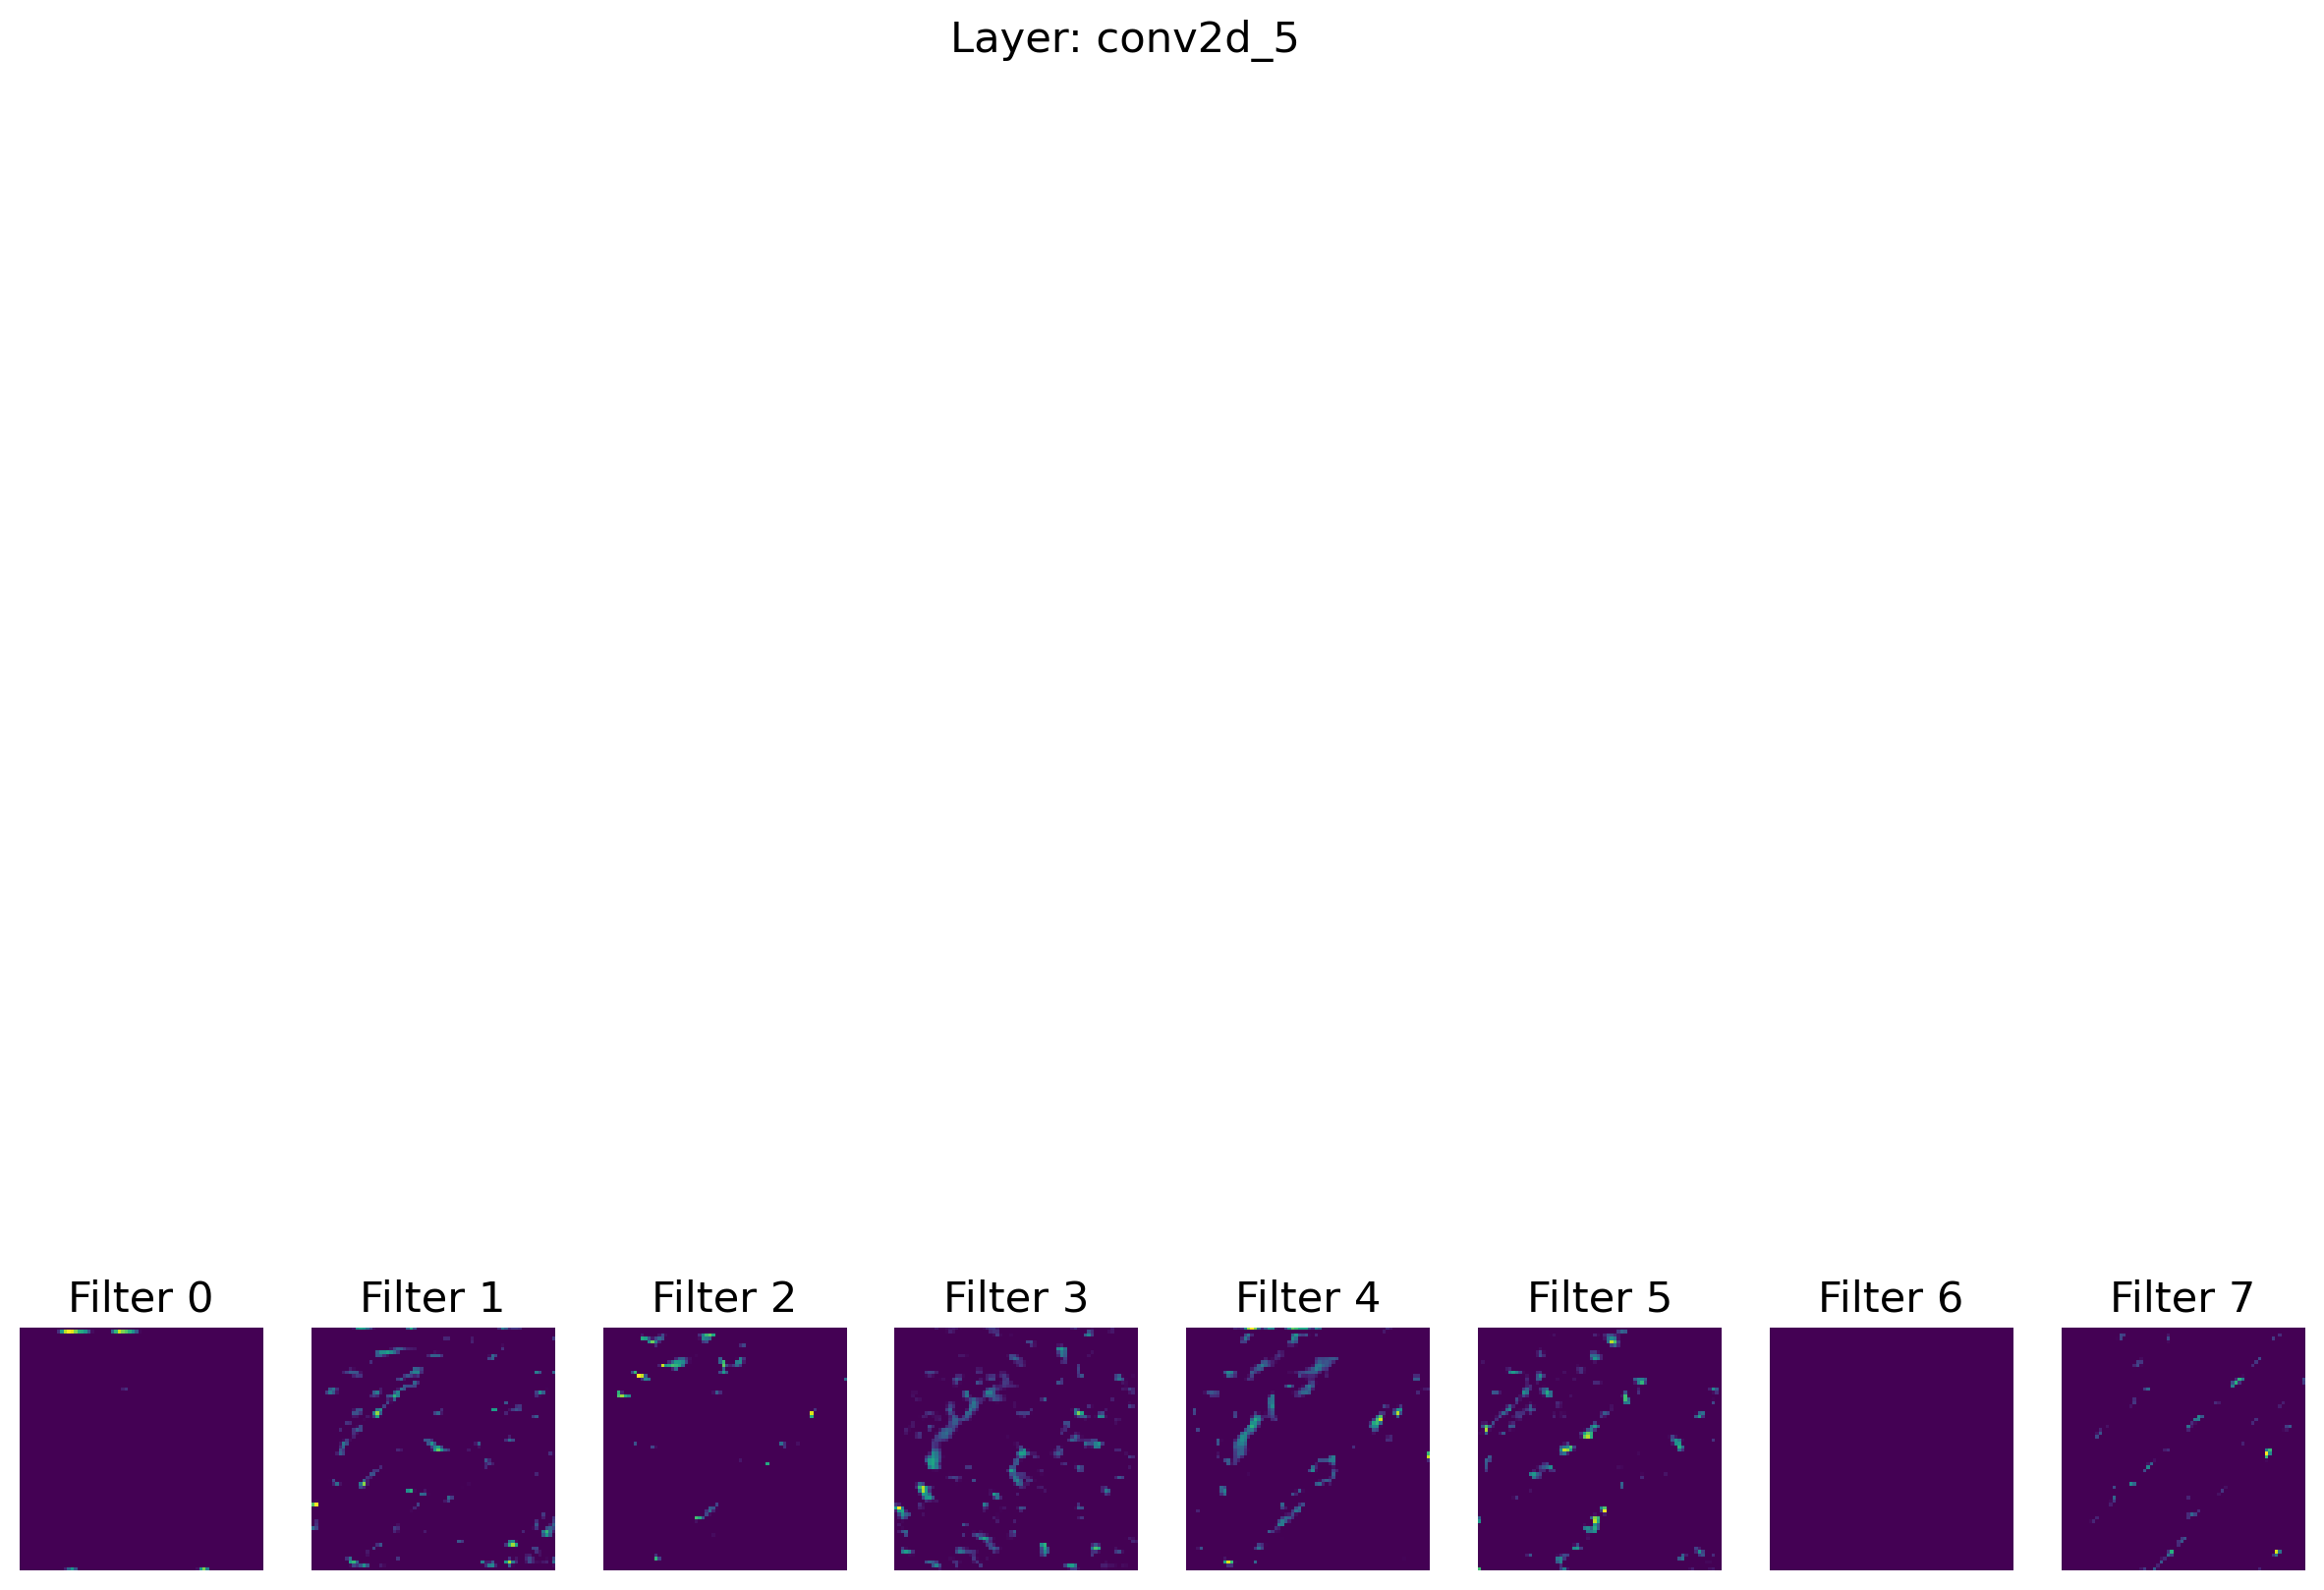

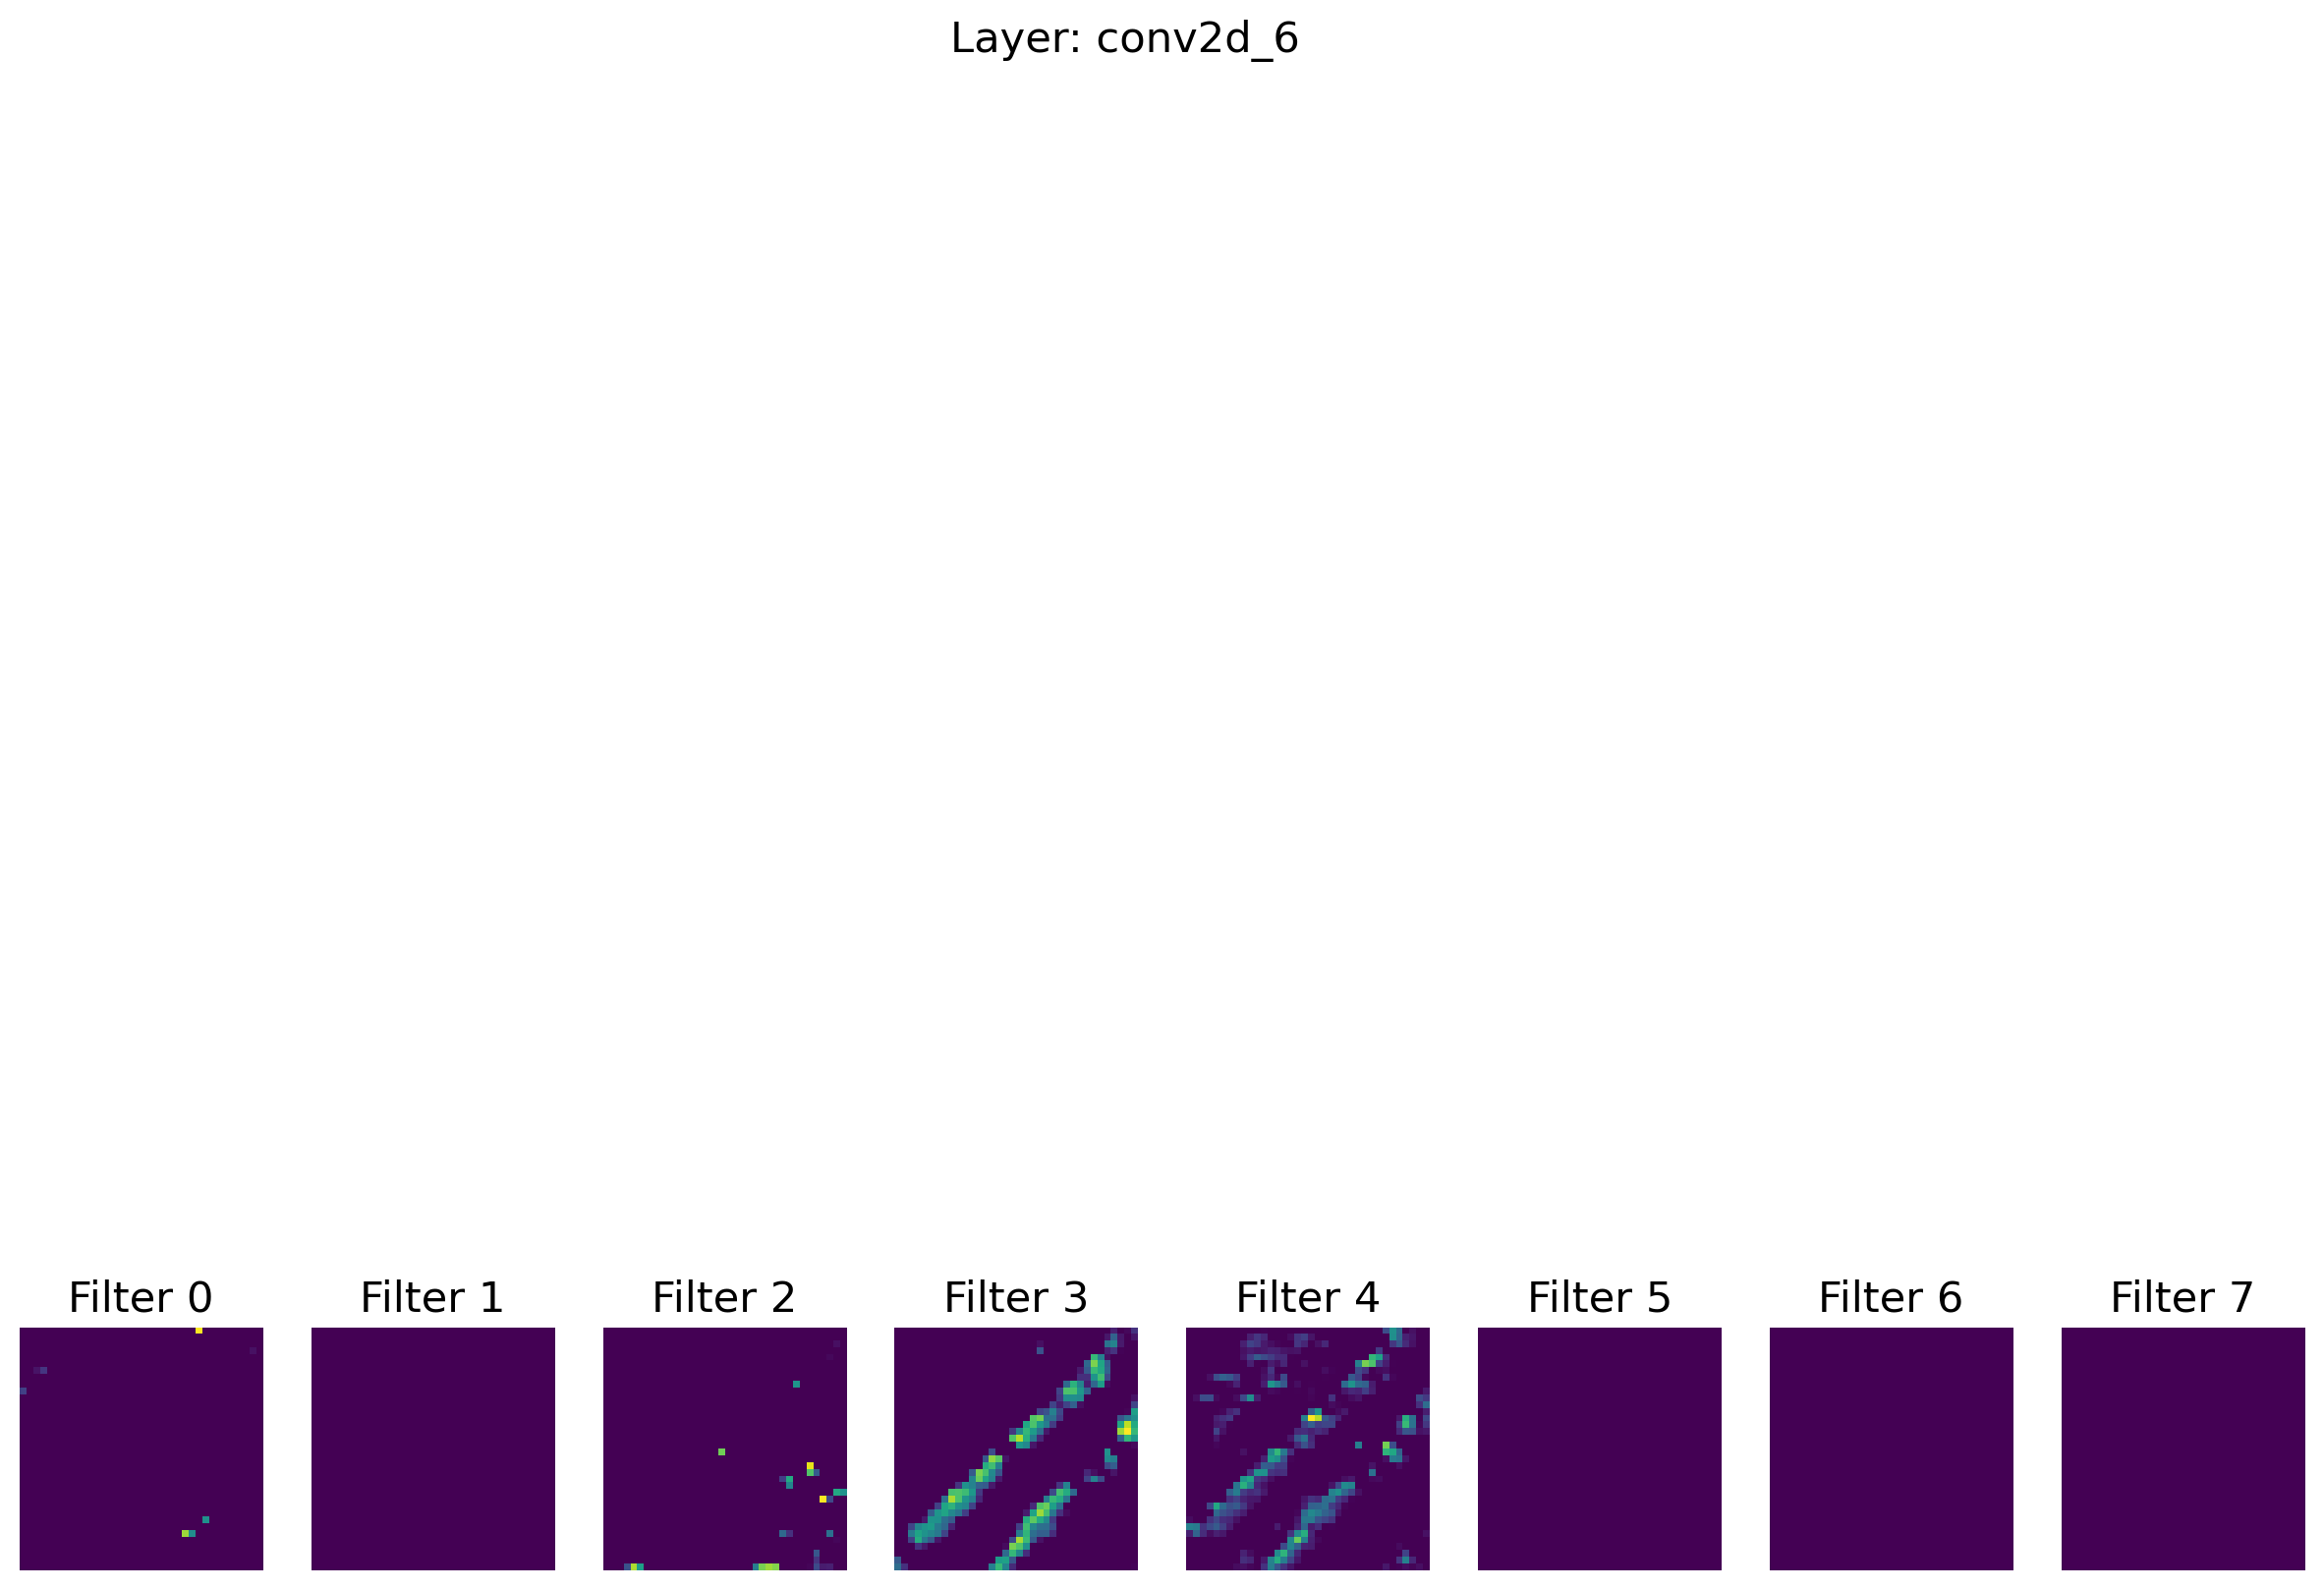

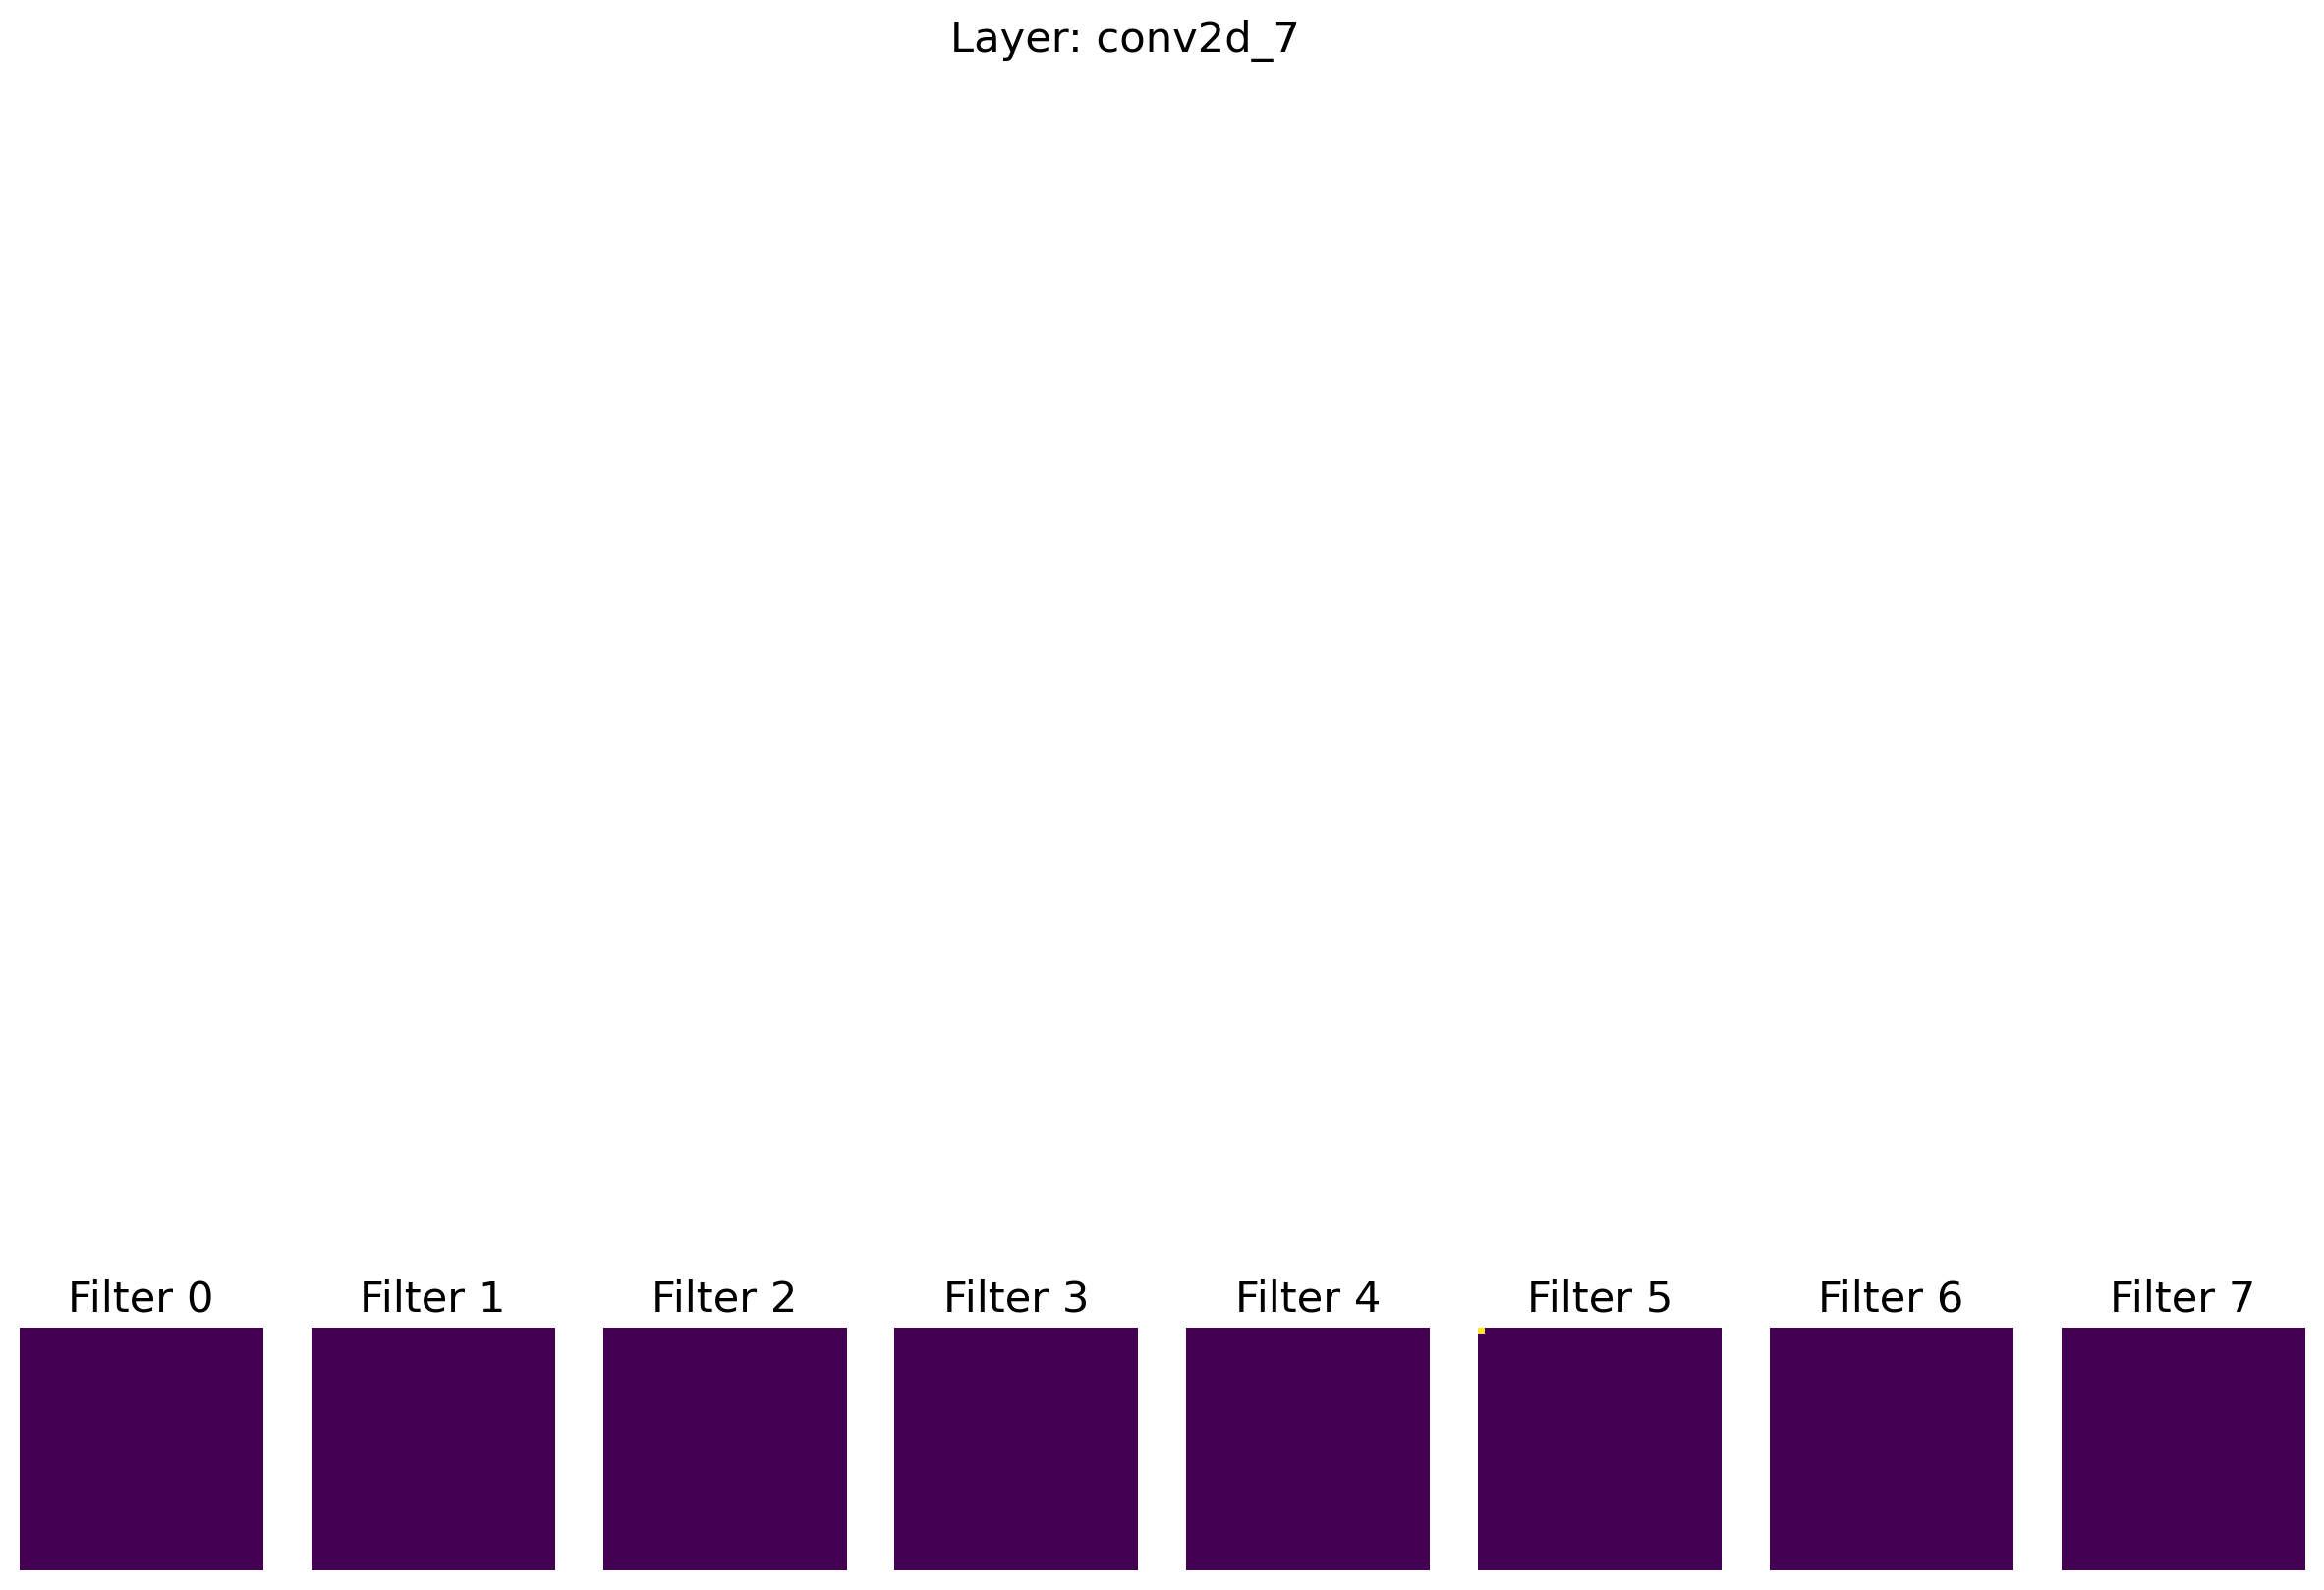

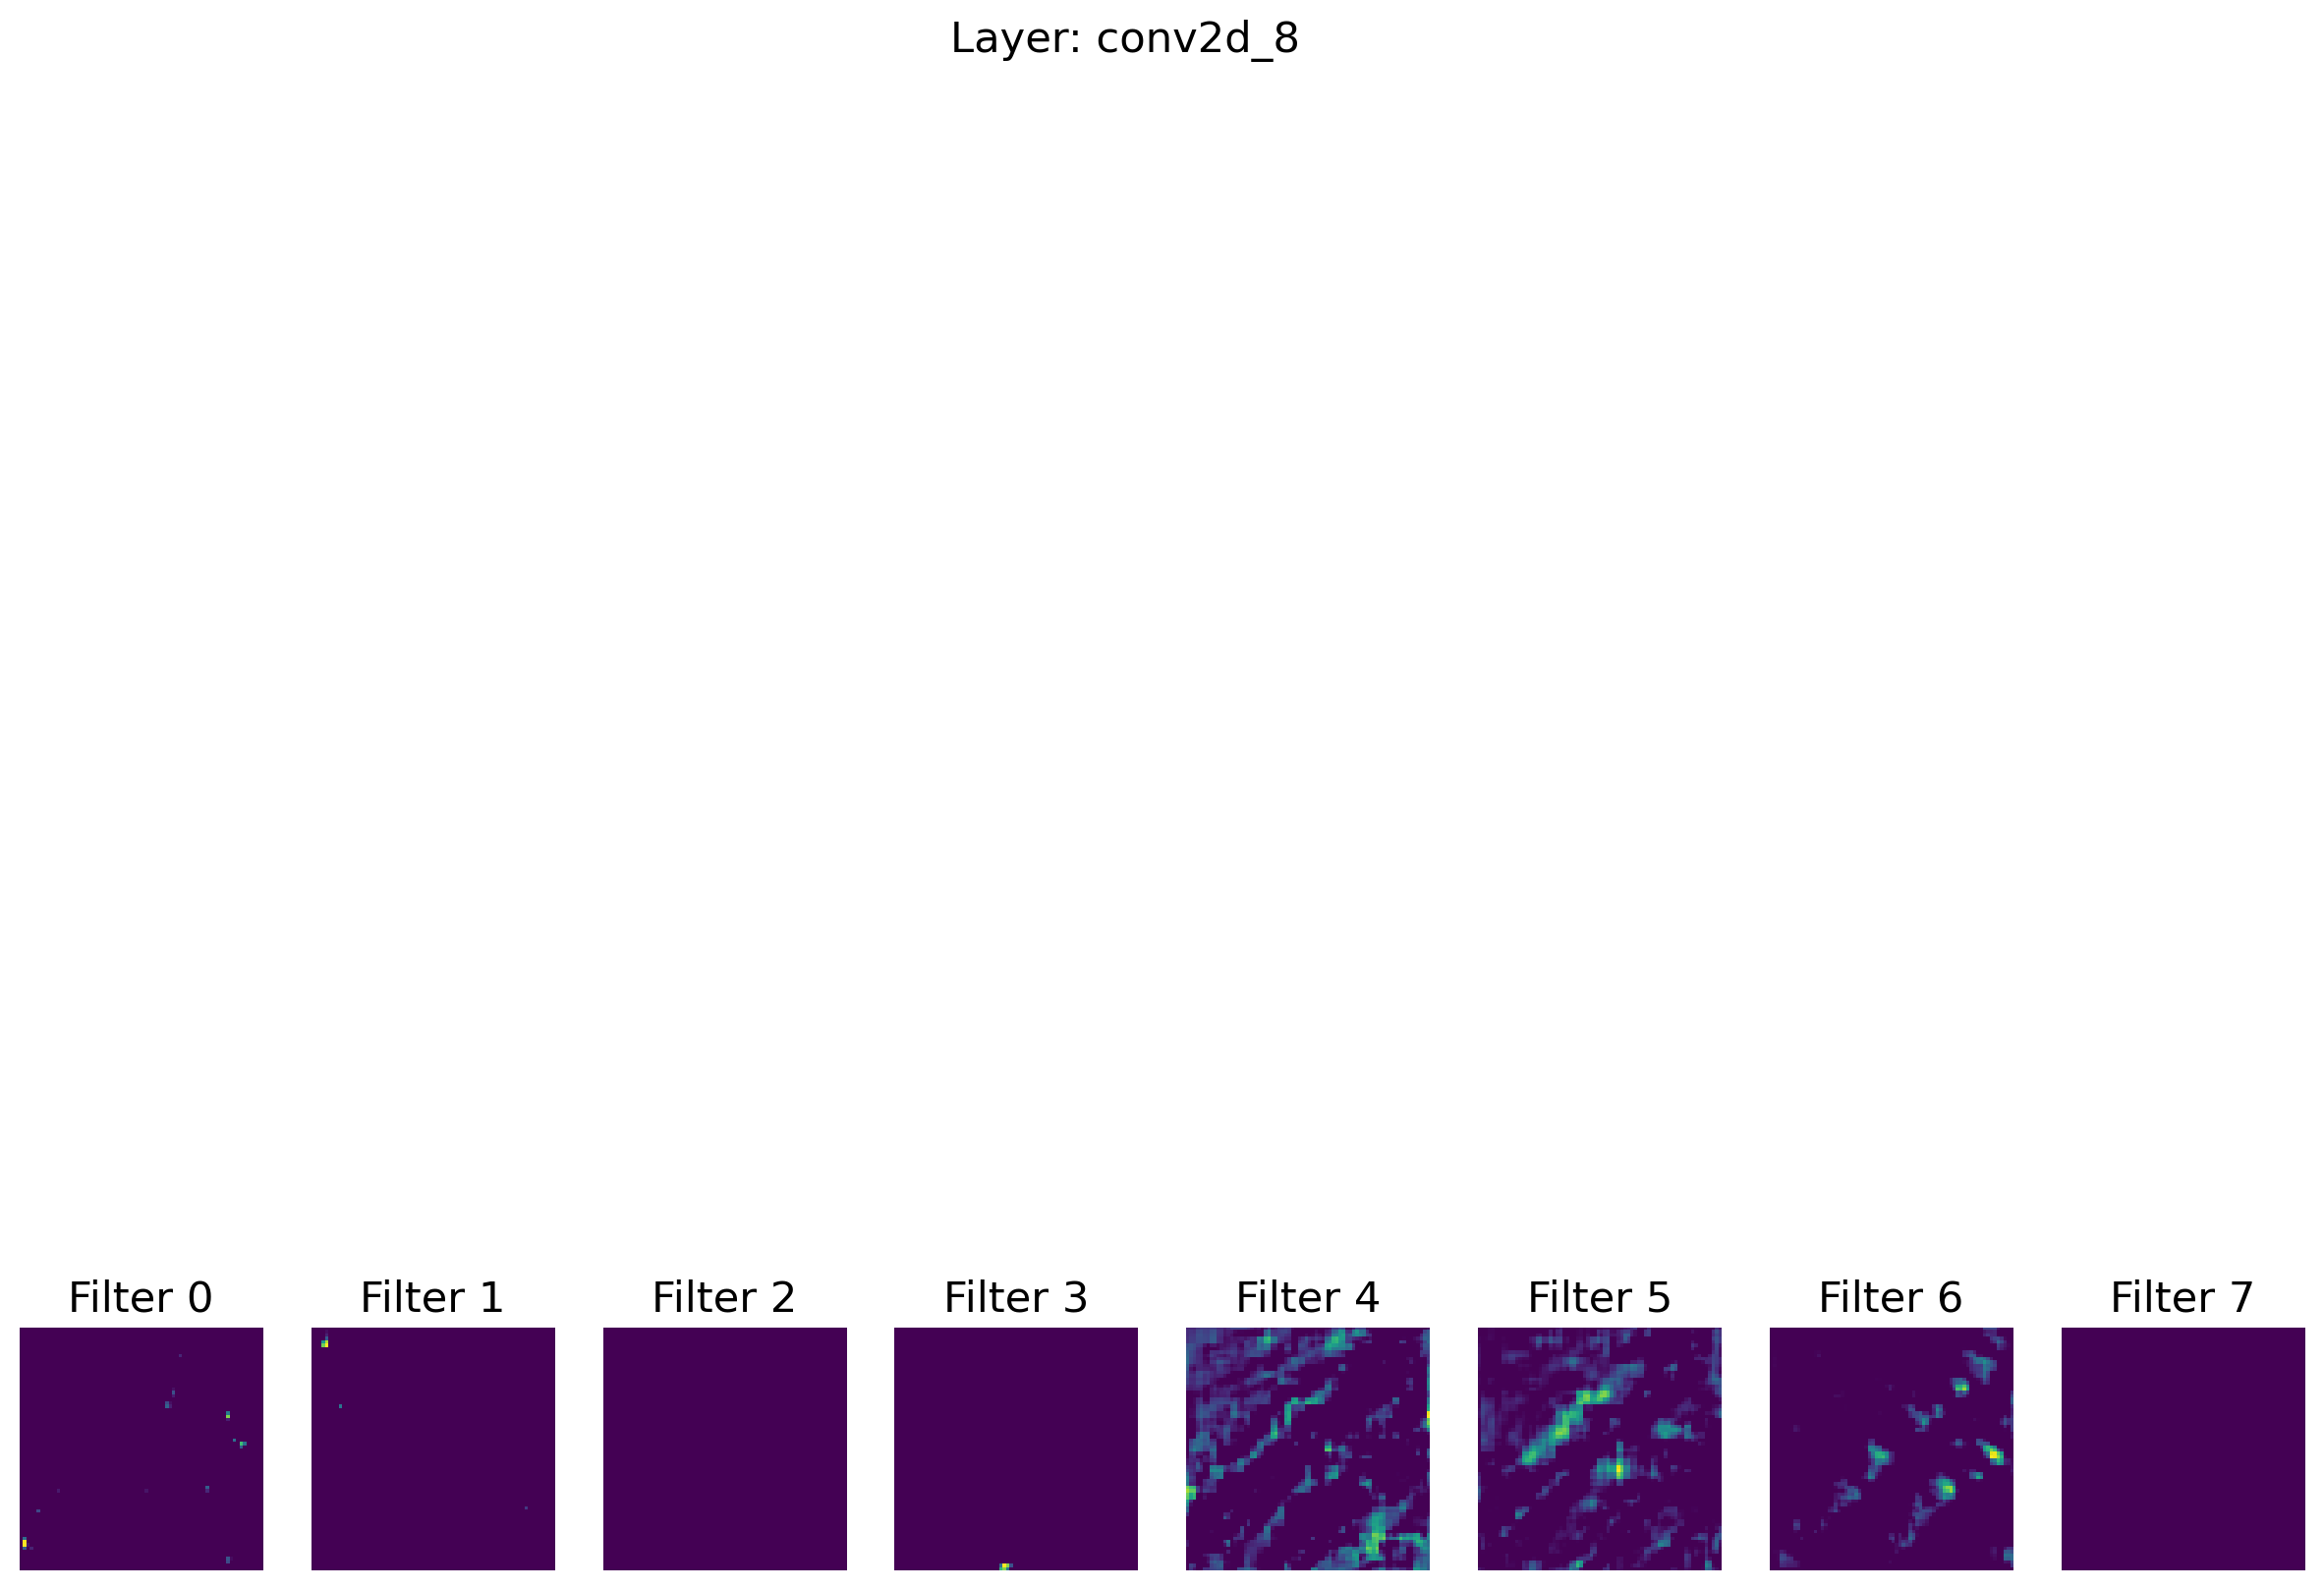

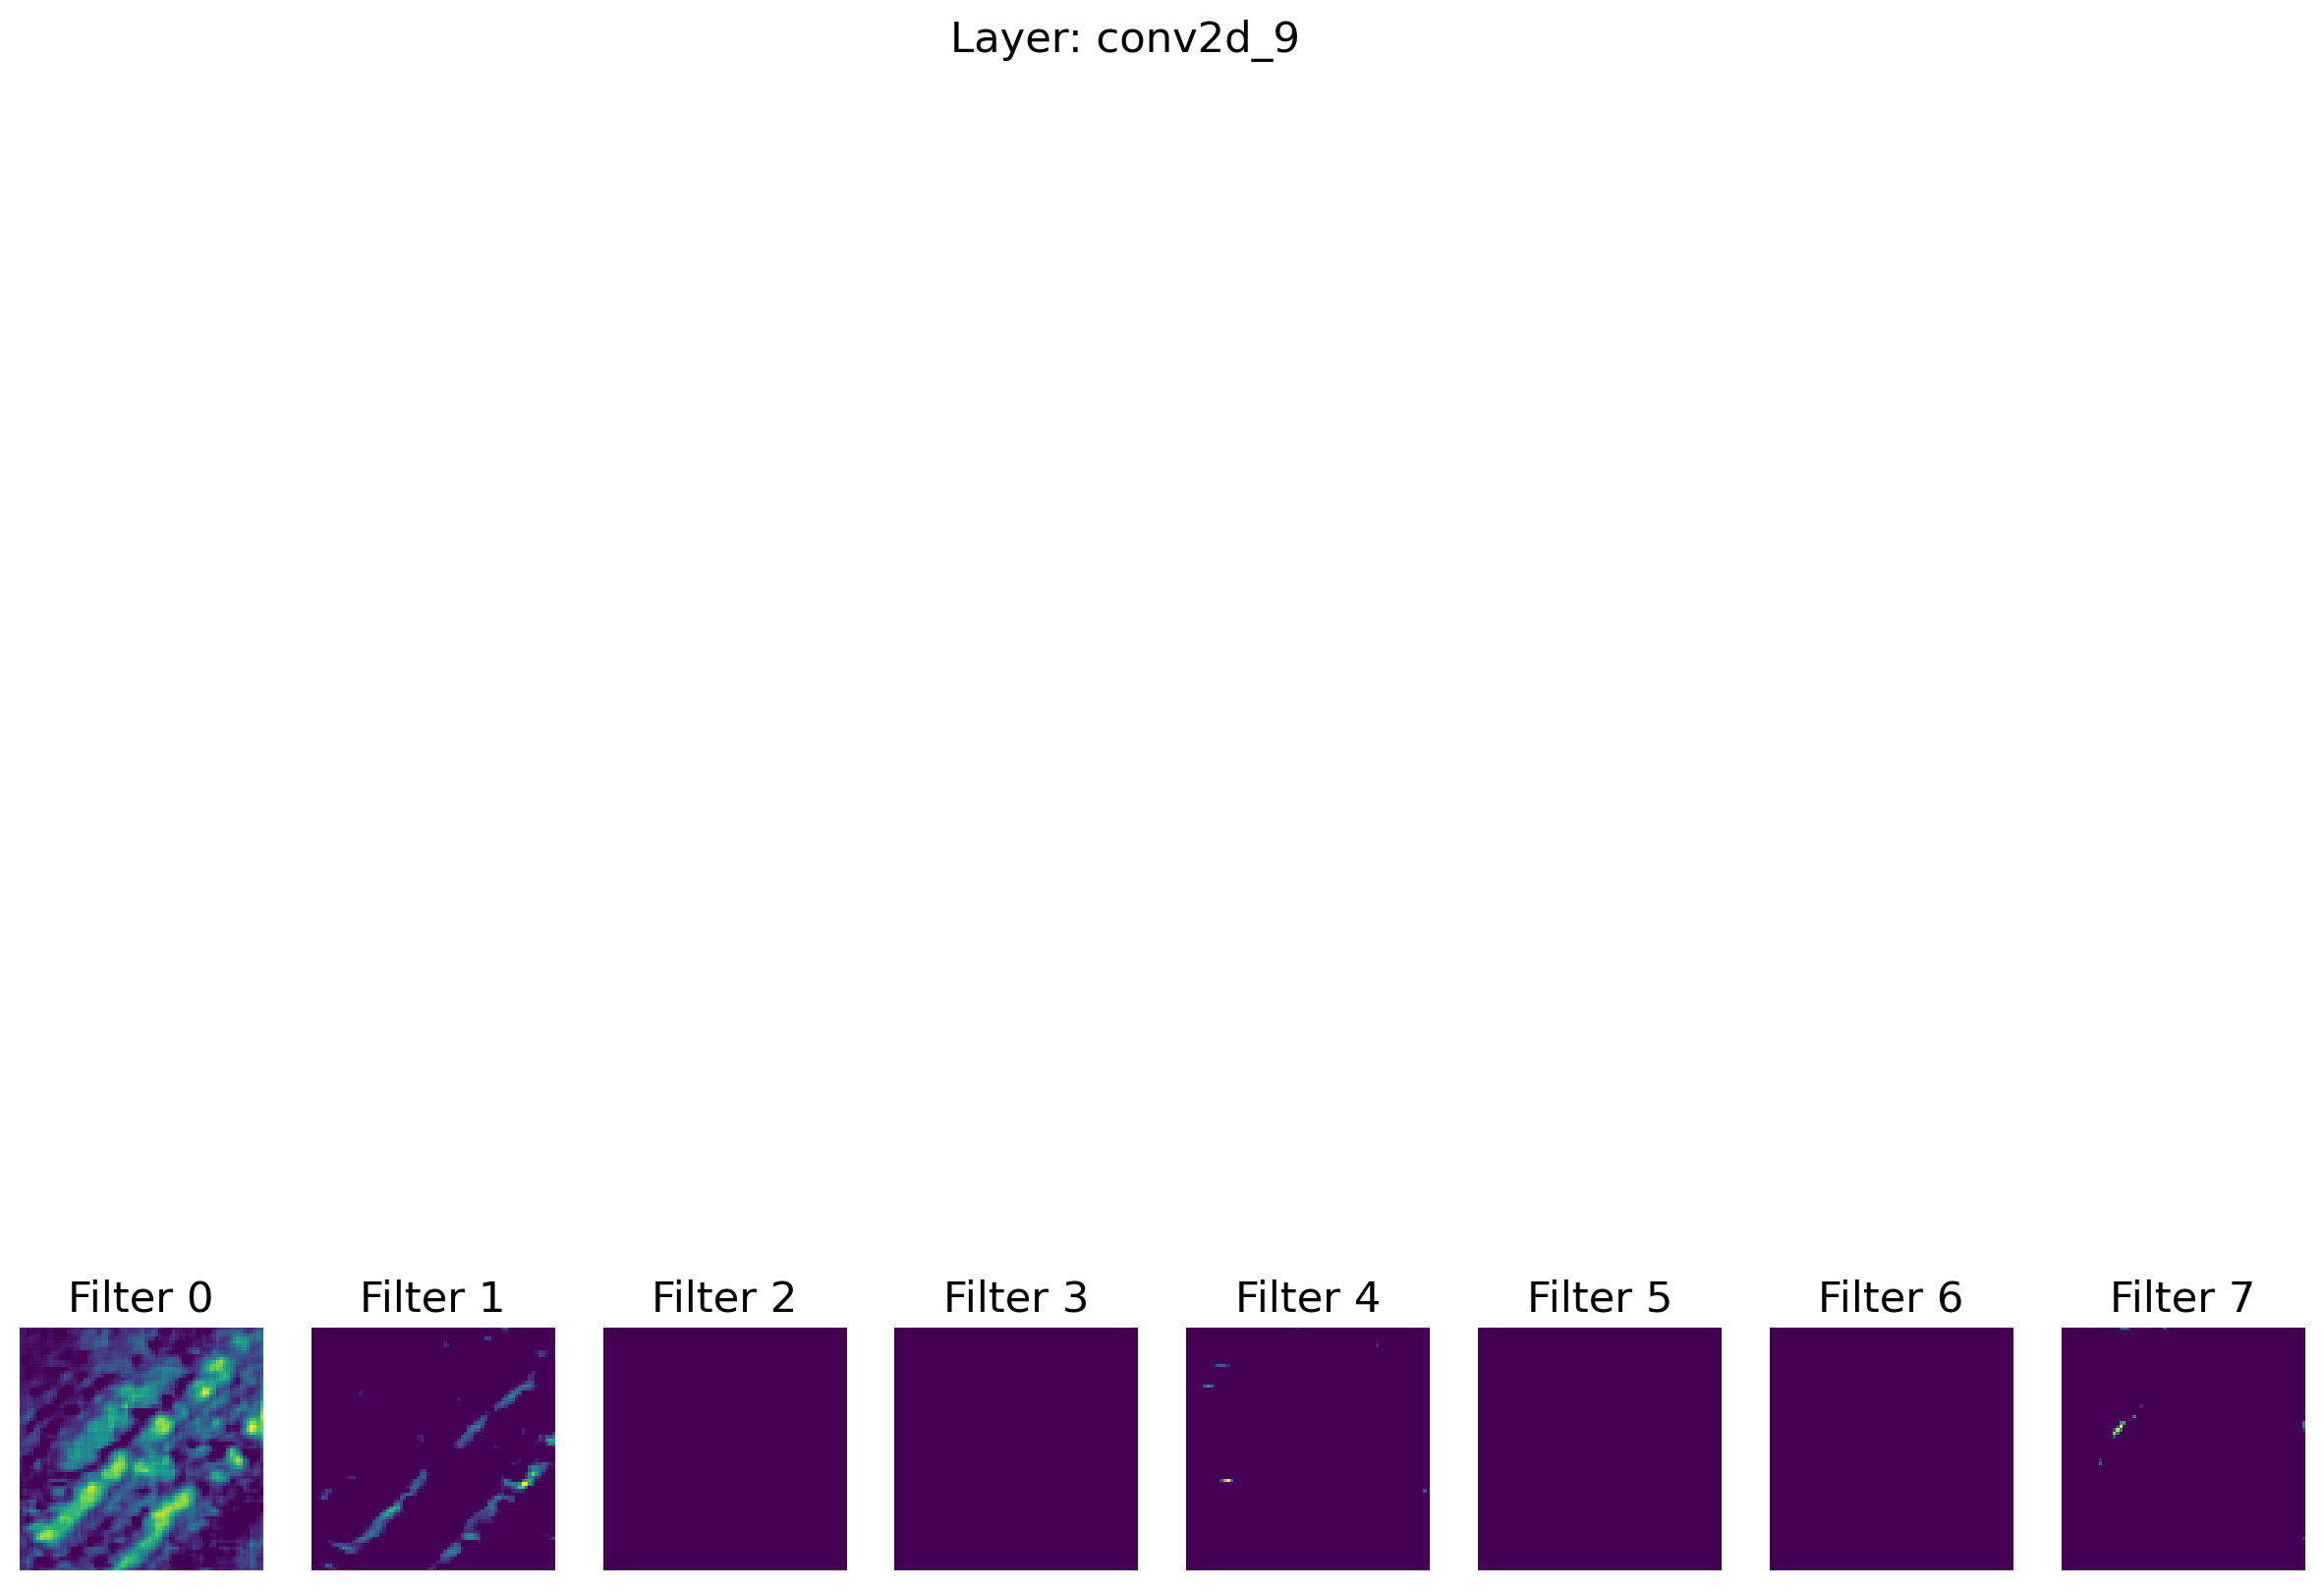

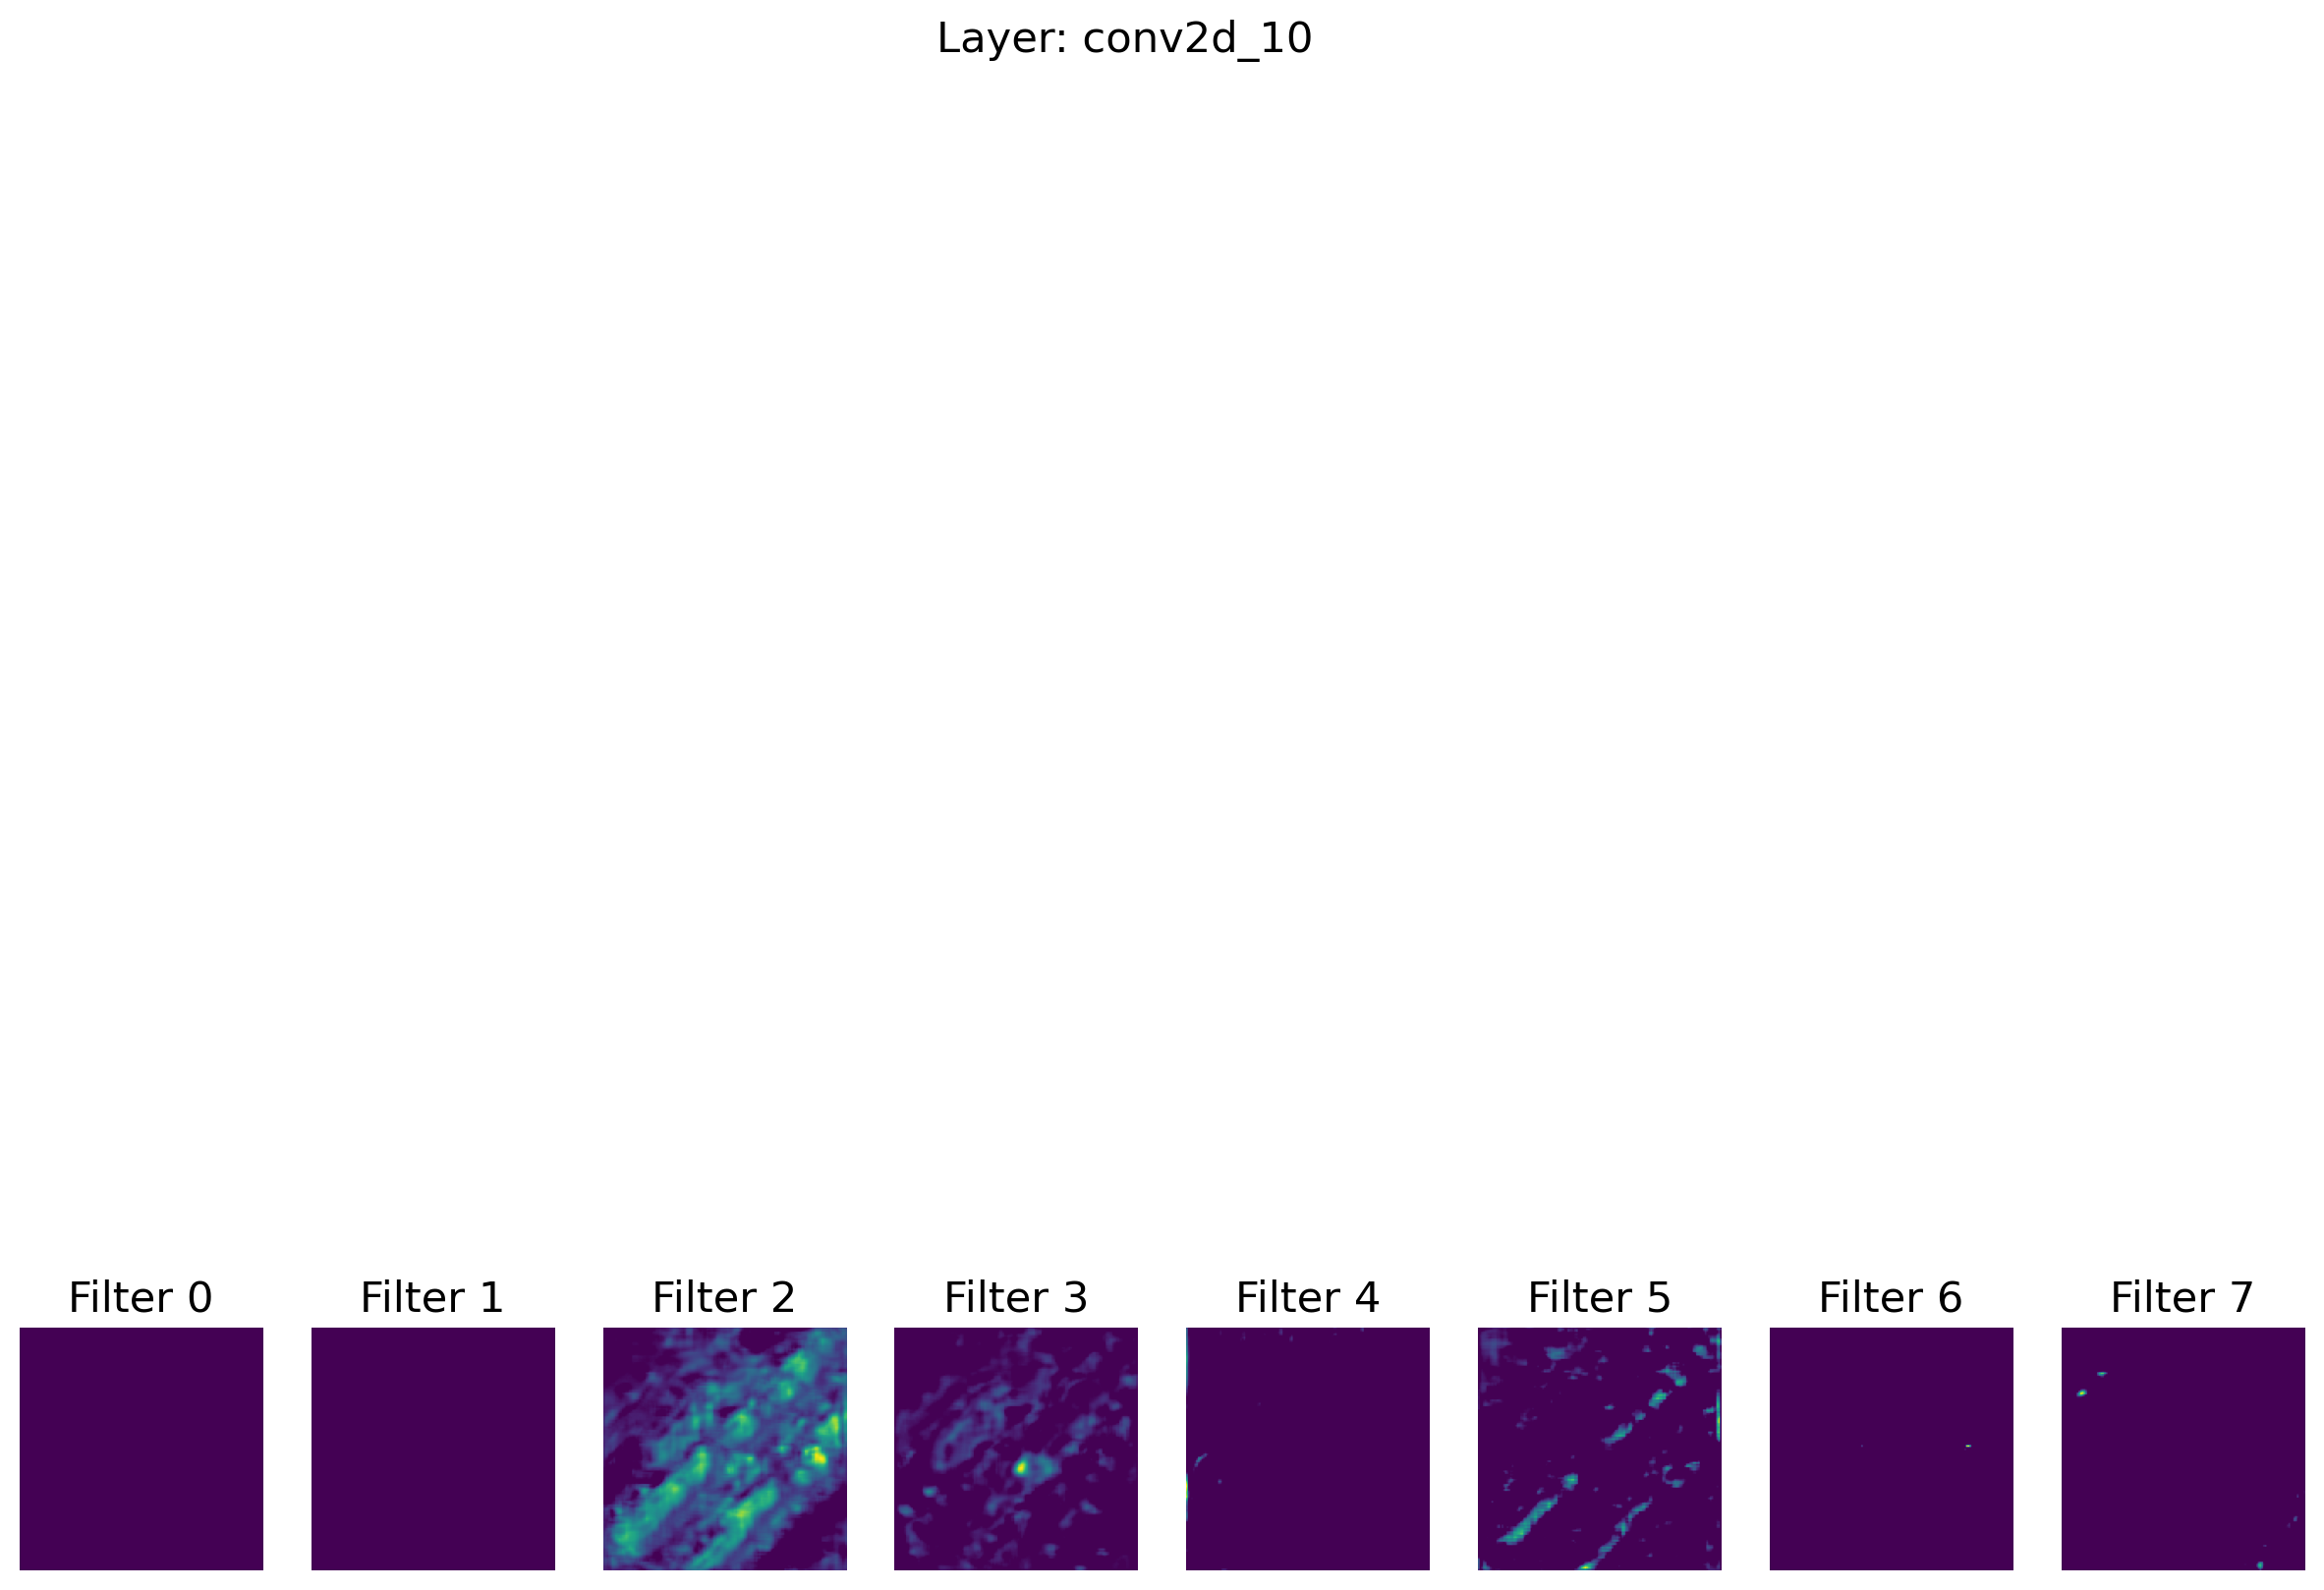

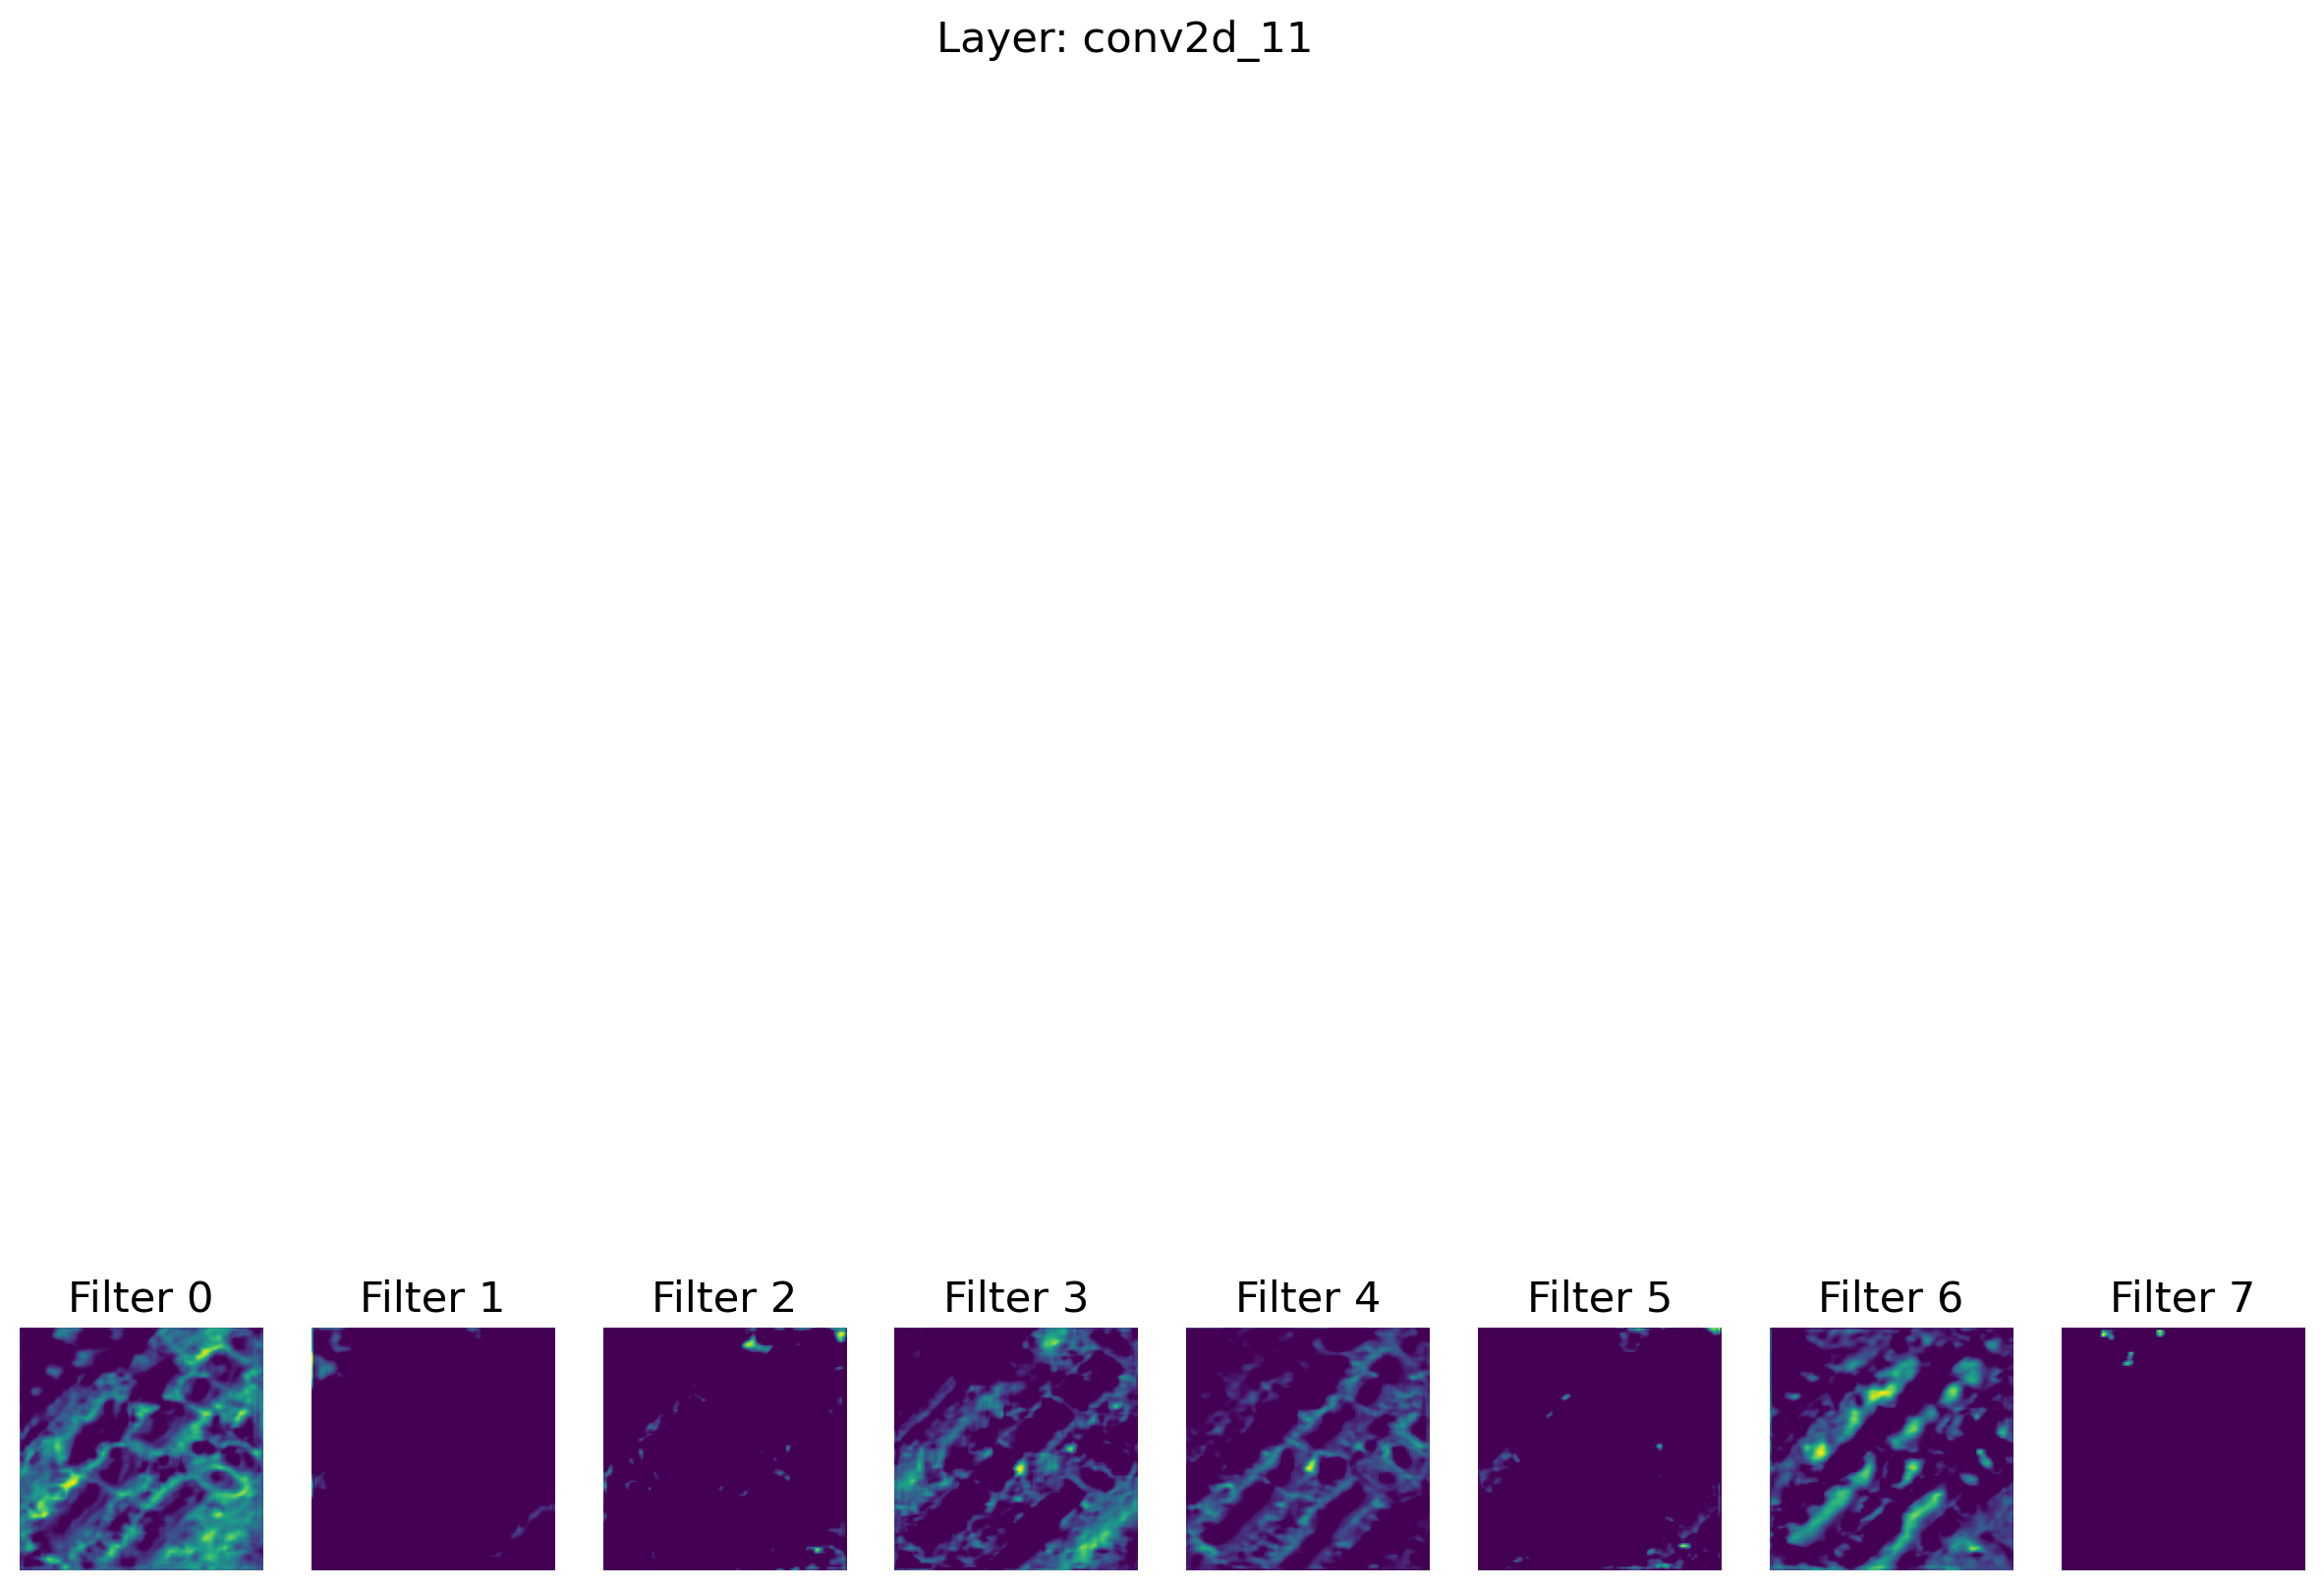

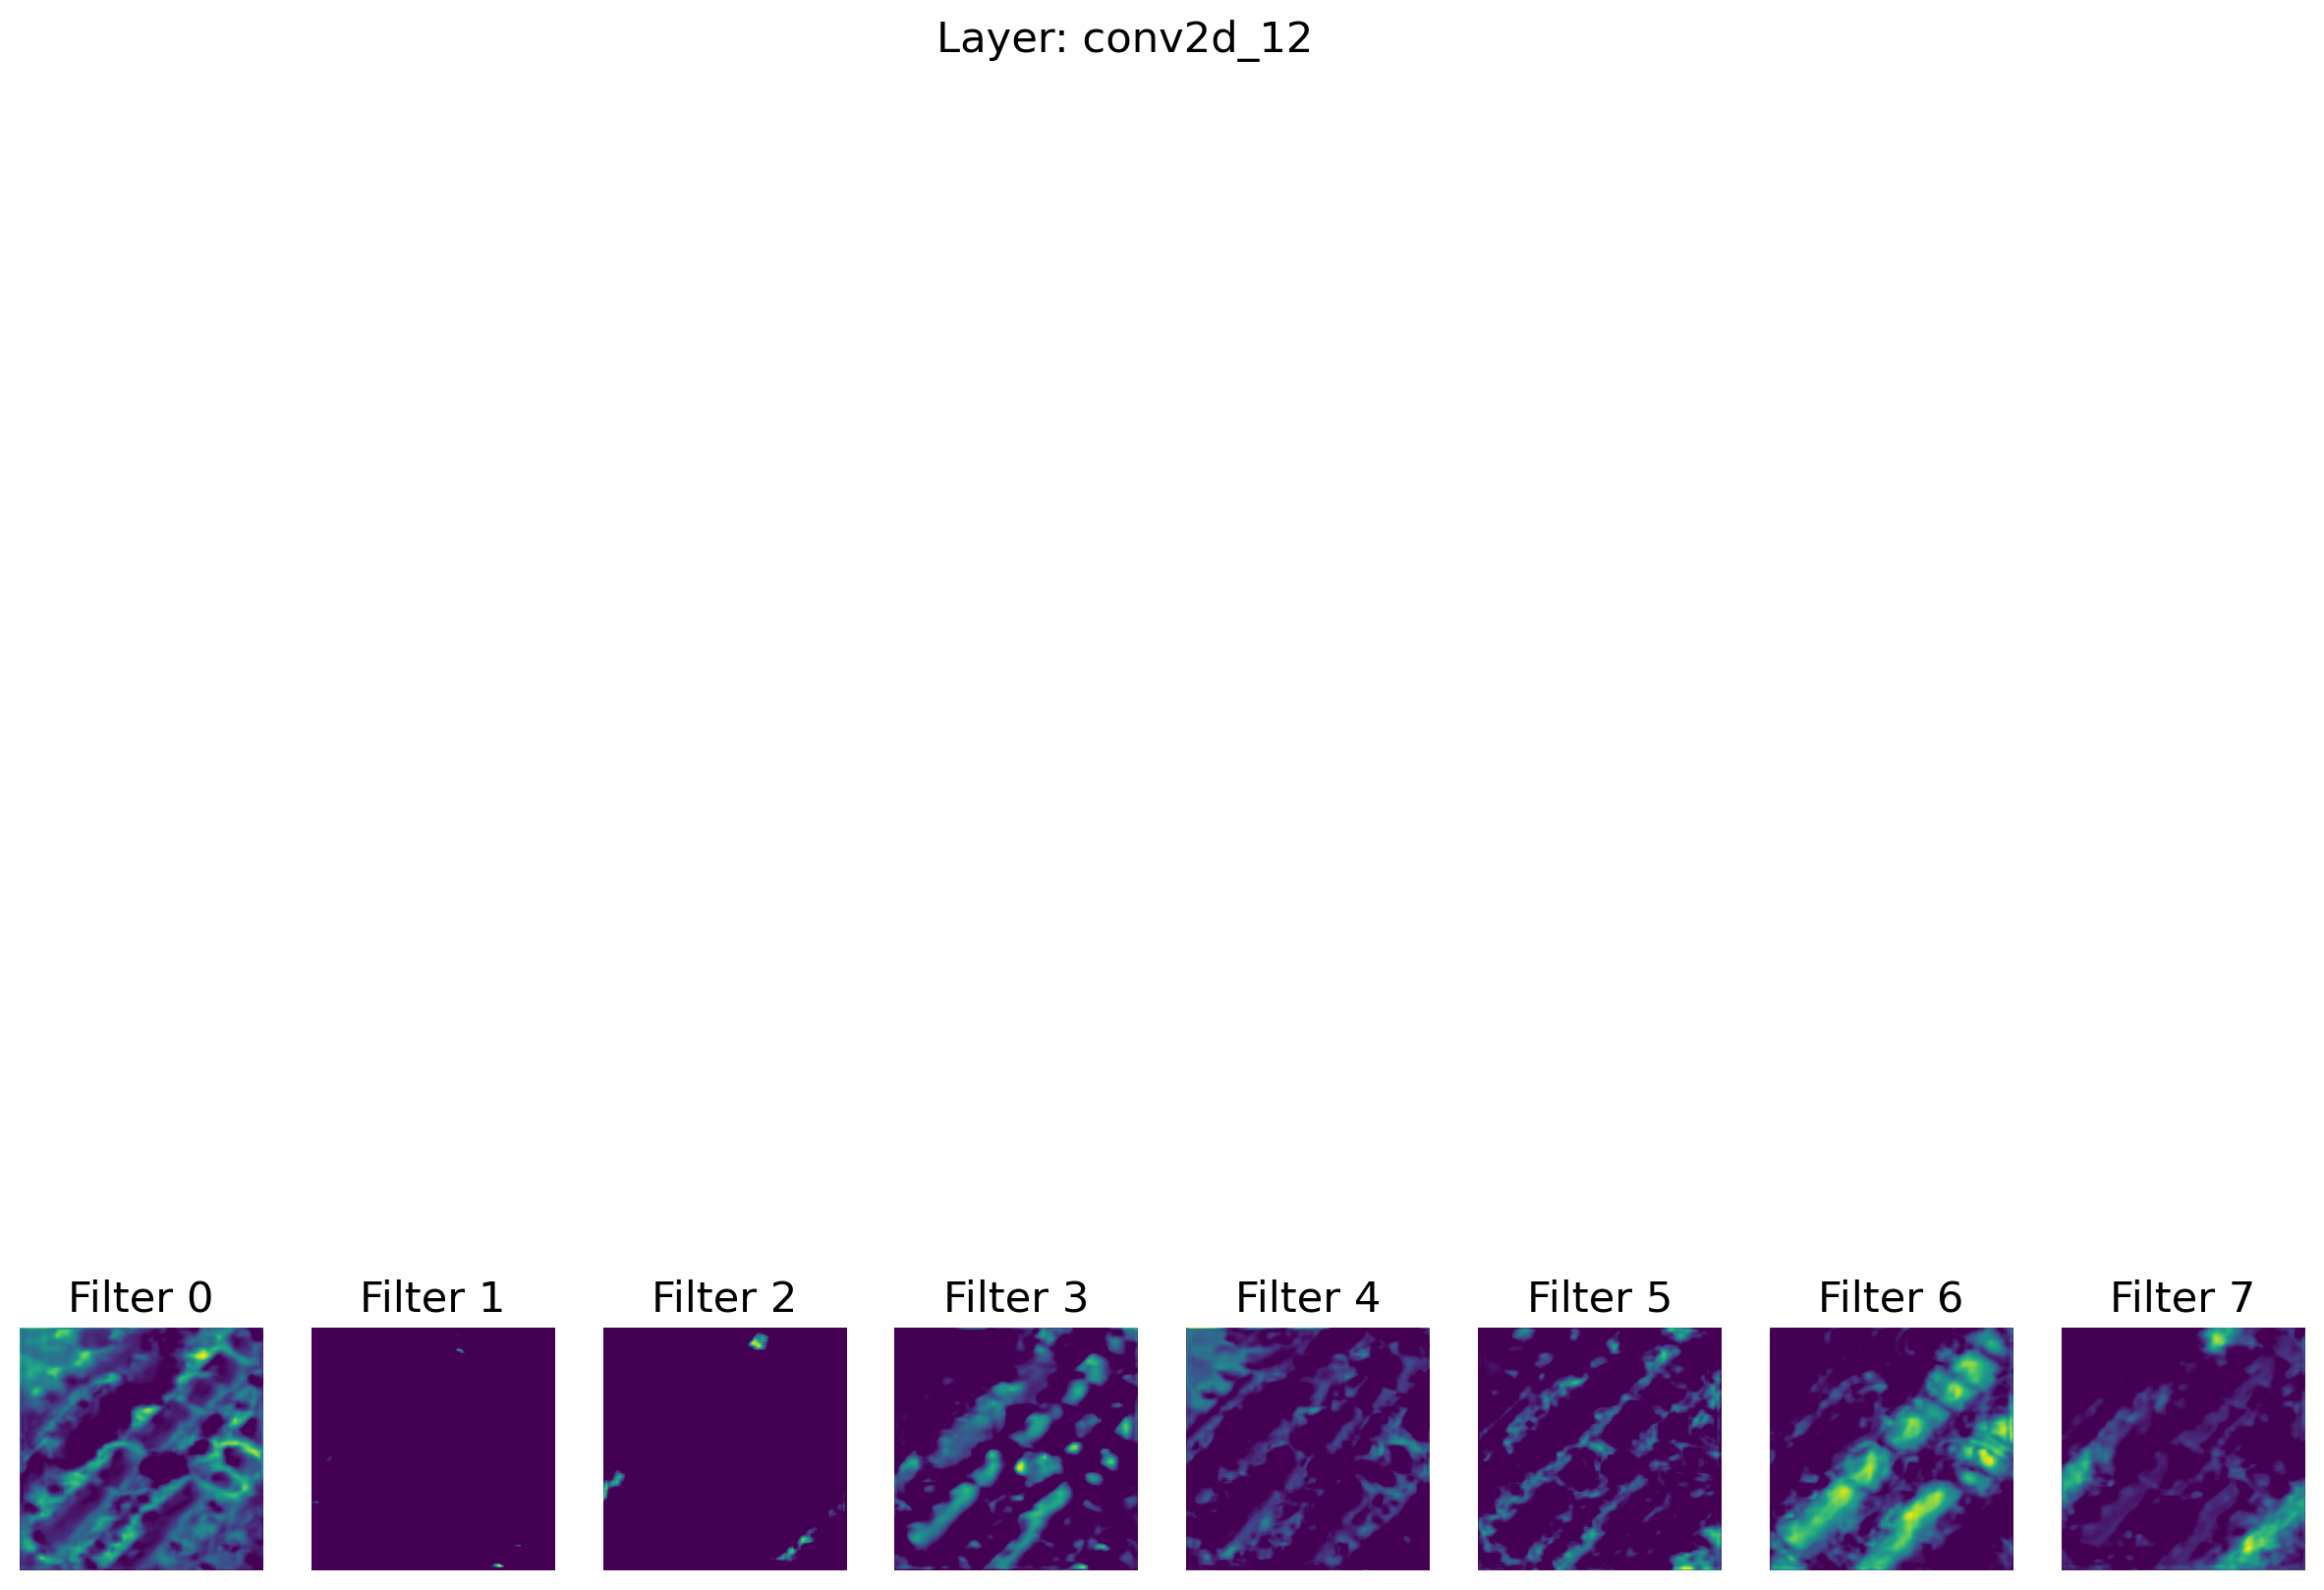

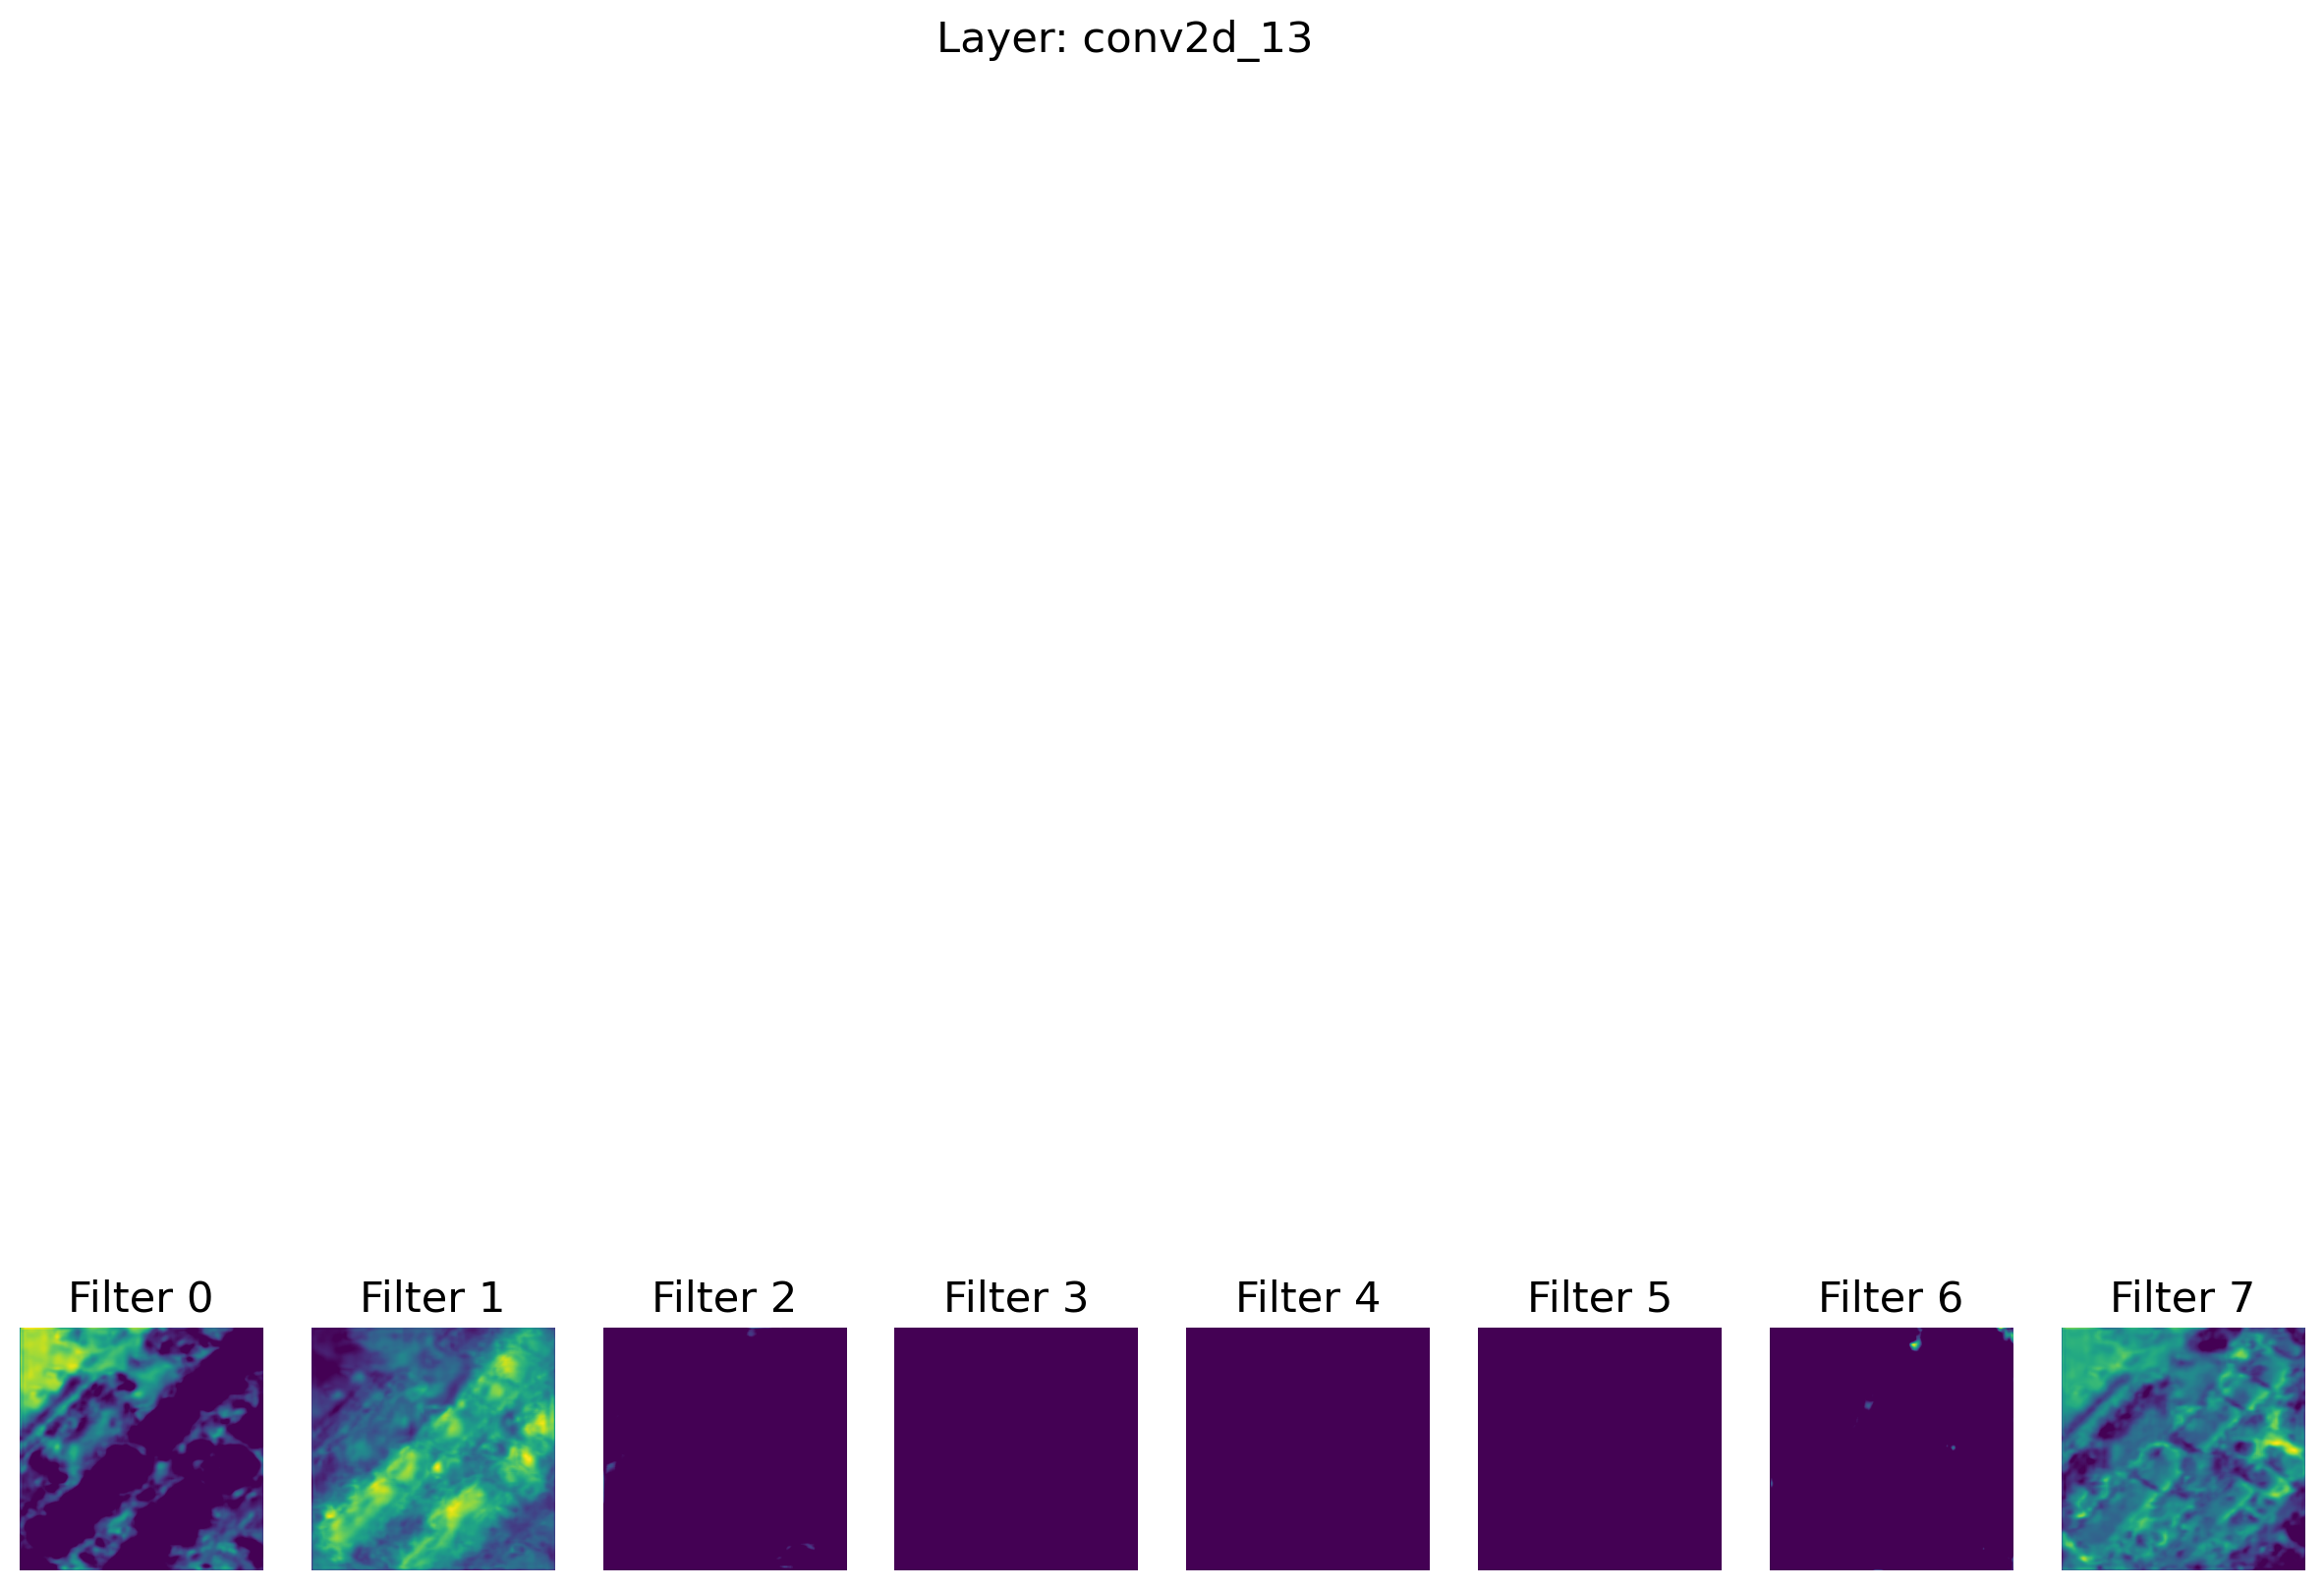

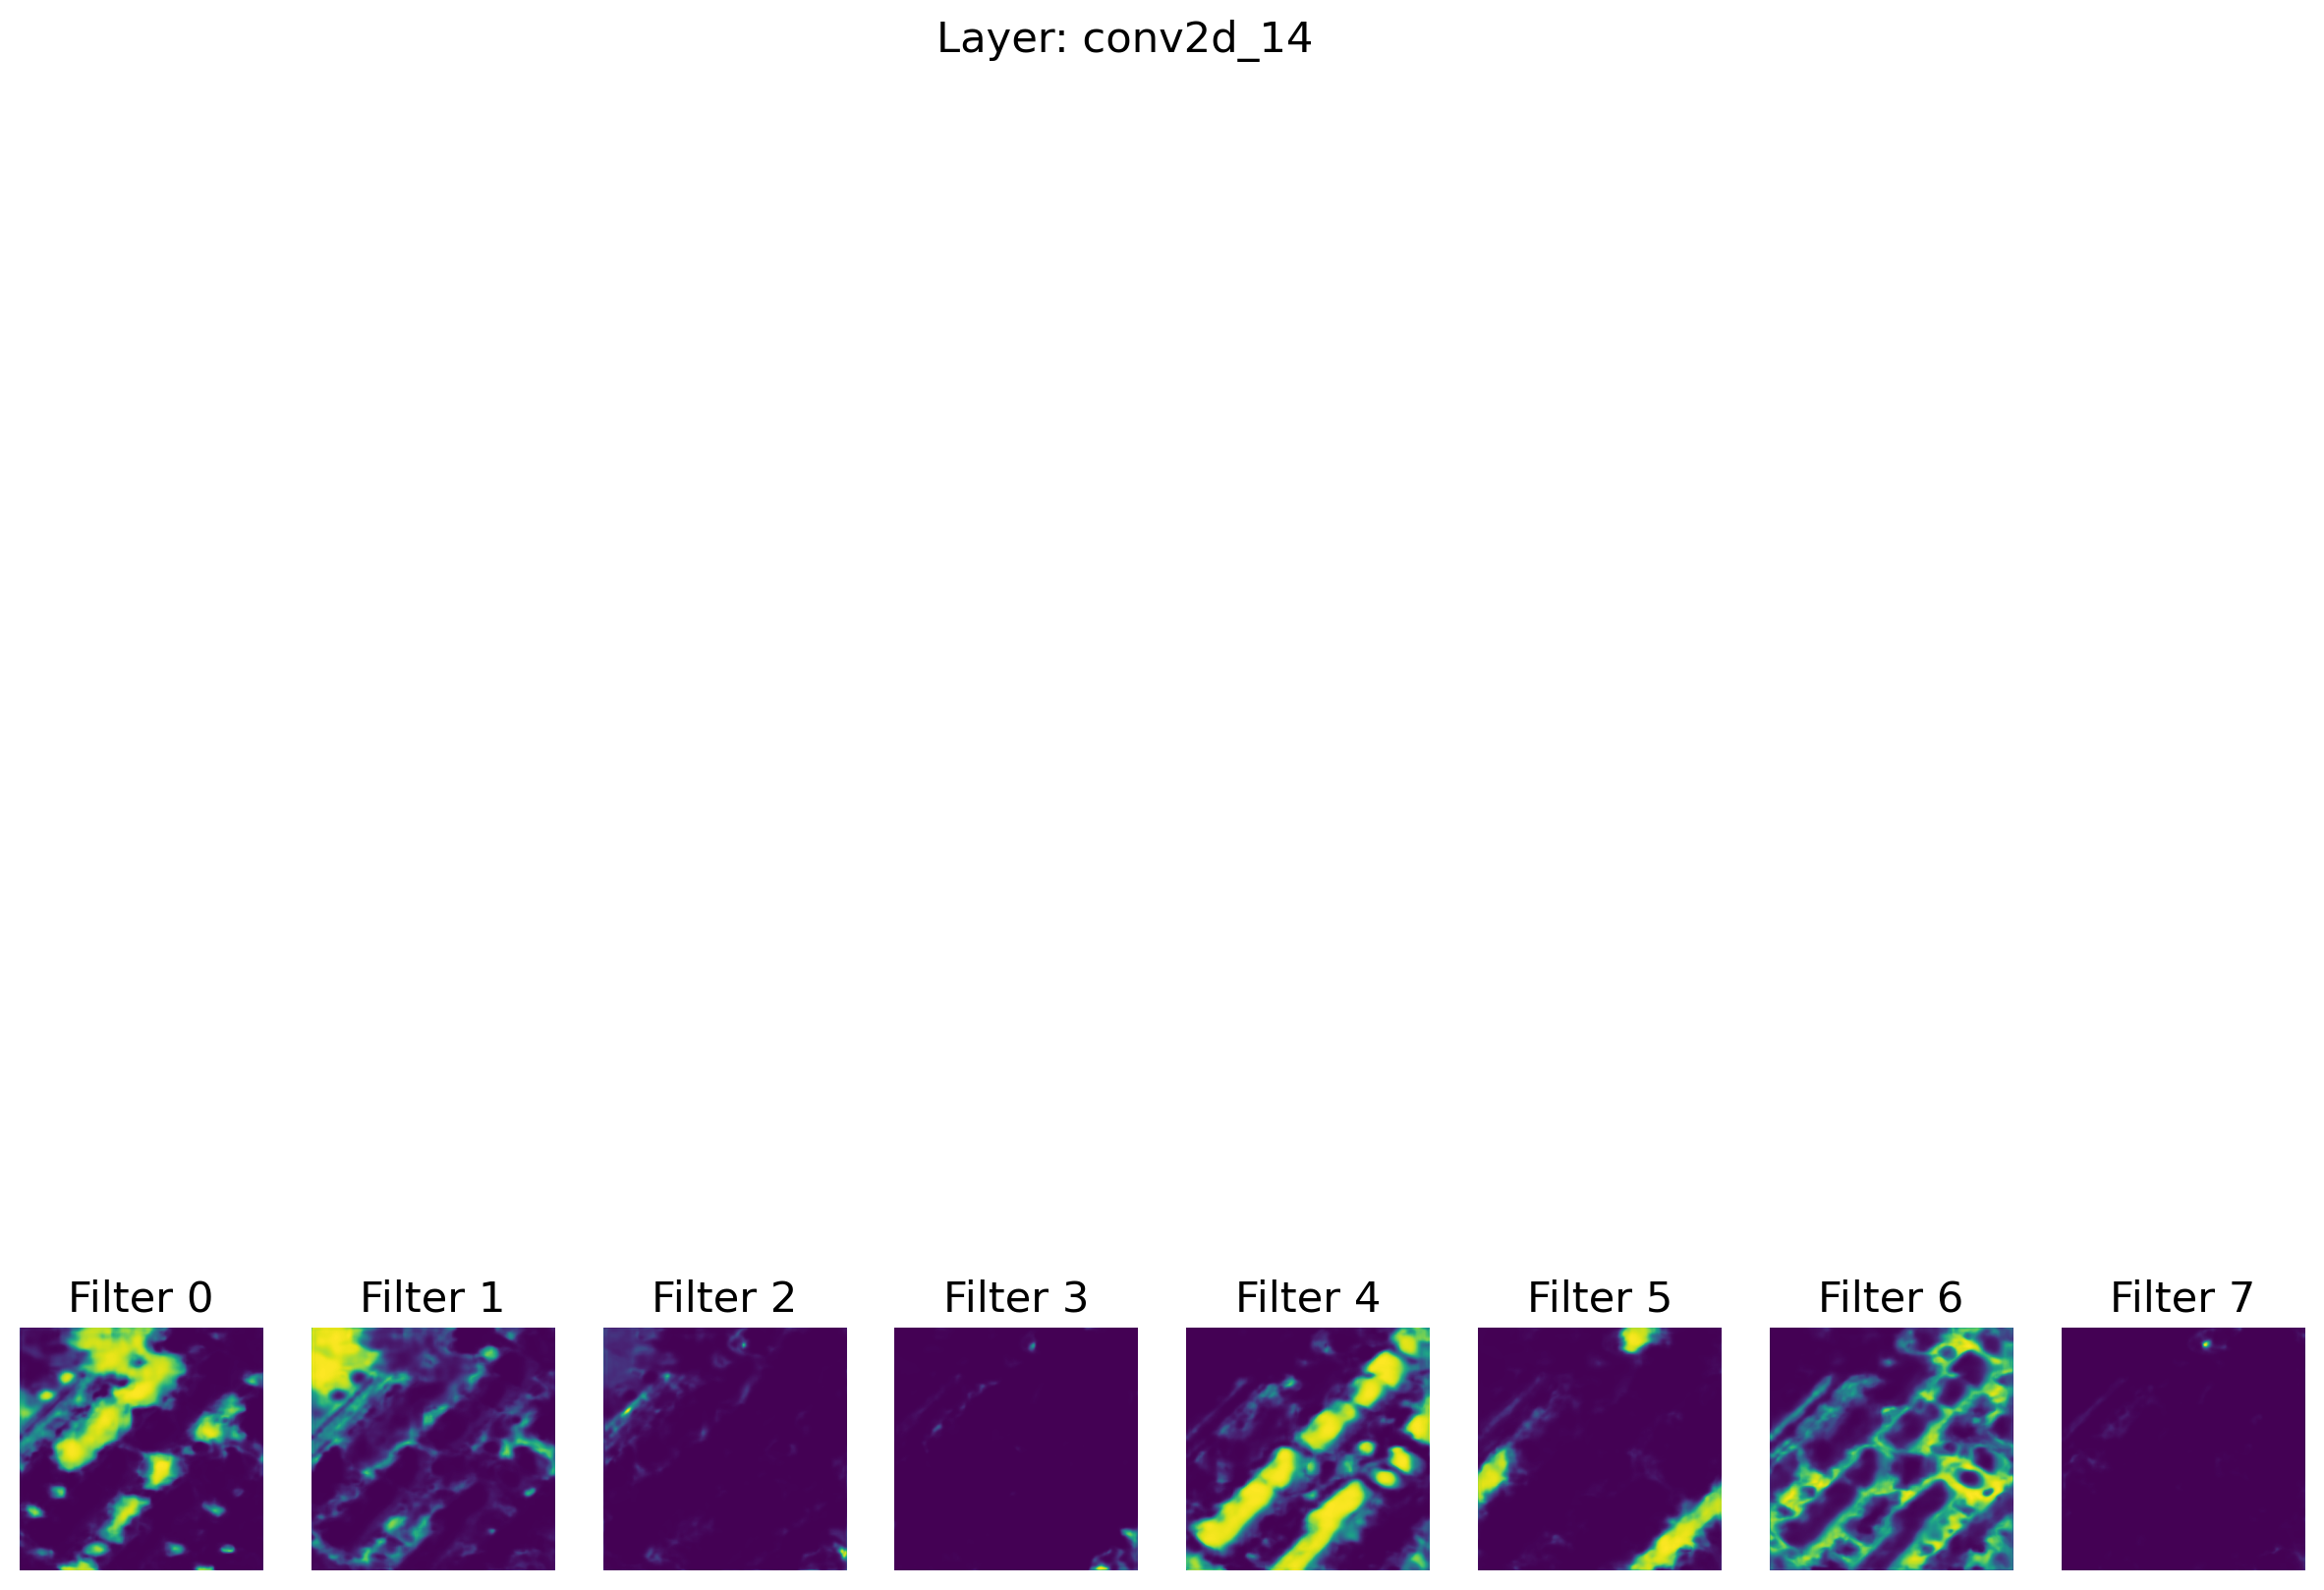

In [22]:
# Create a model to output intermediate activations
#model(X_test[:1])

layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]  # Select conv layers
activation_model = Model(inputs=model.inputs, outputs=layer_outputs)

# Pick a sample input image from X_test
sample_image = X_test[19:20]  # Shape: (1, 288, 288, 2)

# Get feature maps for all convolutional layers
activations = activation_model.predict(sample_image)

# Visualize feature maps for each convolutional layer
def plot_feature_maps(activations, model):
    for layer_name, feature_map in zip([layer.name for layer in model.layers if 'conv' in layer.name], activations):
        num_filters = feature_map.shape[-1]  # Number of filters
        size = feature_map.shape[1]  # Size of feature map (height/width)
        
        plt.figure(figsize=(15, 15))
        plt.suptitle(f"Layer: {layer_name}")
        
        # Plot each filter
        for i in range(min(8, num_filters)):  # Show up to 8 filters
            plt.subplot(1, min(8, num_filters), i + 1)
            plt.imshow(feature_map[0, :, :, i], cmap='viridis')
            plt.axis('off')
            plt.title(f"Filter {i}")
        plt.show()

# Plot feature maps
plot_feature_maps(activations, model)

In [23]:
thermal_data = xar[:data_size, 22:27, :, :].astype(np.float16)  # Thermal Data (Layer 23-27)
thermal_data = np.stack([thermal_data[:, i, :, :] for i in range(5) if i != 3], axis=-1)
thermal_data.shape

(3000, 288, 288, 4)

In [24]:
#thermal_data[0, :, :, 4]

In [25]:
thermal_avg = np.mean(np.mean(np.mean(thermal_data, axis=3), axis = 2), axis=1)
thermal_avg

array([2634., 2668., 3036., ..., 2852., 2740., 2716.], dtype=float16)

In [26]:
def calculate_green_ratio(land_cover_map, green_classes):
    """
    Calculate the ratio of green areas in the land cover map
    
    Parameters:
    - land_cover_map: 3D numpy array representing land cover classification for multiple samples
    - green_classes: list of class values representing green areas
    
    Returns:
    - 1D numpy array of green area ratios, one for each sample
    """
    # Create a boolean mask for green areas
    green_mask = np.isin(land_cover_map, green_classes)
    
    # Calculate green area ratio for each sample
    green_ratios = np.sum(green_mask, axis=(1, 2)) / (land_cover_map.shape[1] * land_cover_map.shape[2])
    
    return green_ratios


green_classes = [0, 1]
green_ratios = calculate_green_ratio(landcover[:data_size], green_classes)

for i, ratio in enumerate(green_ratios):
    print(f"Sample {i}: Green Area Ratio: {ratio:.4f} ({ratio*100:.2f}%)")

Sample 0: Green Area Ratio: 0.7990 (79.90%)
Sample 1: Green Area Ratio: 0.8168 (81.68%)
Sample 2: Green Area Ratio: 0.4515 (45.15%)
Sample 3: Green Area Ratio: 0.3092 (30.92%)
Sample 4: Green Area Ratio: 0.5122 (51.22%)
Sample 5: Green Area Ratio: 0.4652 (46.52%)
Sample 6: Green Area Ratio: 0.0982 (9.82%)
Sample 7: Green Area Ratio: 0.0382 (3.82%)
Sample 8: Green Area Ratio: 0.4238 (42.38%)
Sample 9: Green Area Ratio: 0.1202 (12.02%)
Sample 10: Green Area Ratio: 0.2581 (25.81%)
Sample 11: Green Area Ratio: 0.3464 (34.64%)
Sample 12: Green Area Ratio: 0.3358 (33.58%)
Sample 13: Green Area Ratio: 0.0840 (8.40%)
Sample 14: Green Area Ratio: 0.0578 (5.78%)
Sample 15: Green Area Ratio: 0.0362 (3.62%)
Sample 16: Green Area Ratio: 0.3749 (37.49%)
Sample 17: Green Area Ratio: 0.0591 (5.91%)
Sample 18: Green Area Ratio: 0.1448 (14.48%)
Sample 19: Green Area Ratio: 0.0520 (5.20%)
Sample 20: Green Area Ratio: 0.0377 (3.77%)
Sample 21: Green Area Ratio: 0.0815 (8.15%)
Sample 22: Green Area Ratio: 

In [27]:
len(thermal_avg)

3000

In [28]:
len(green_ratios)

3000

<Figure size 1000x600 with 0 Axes>

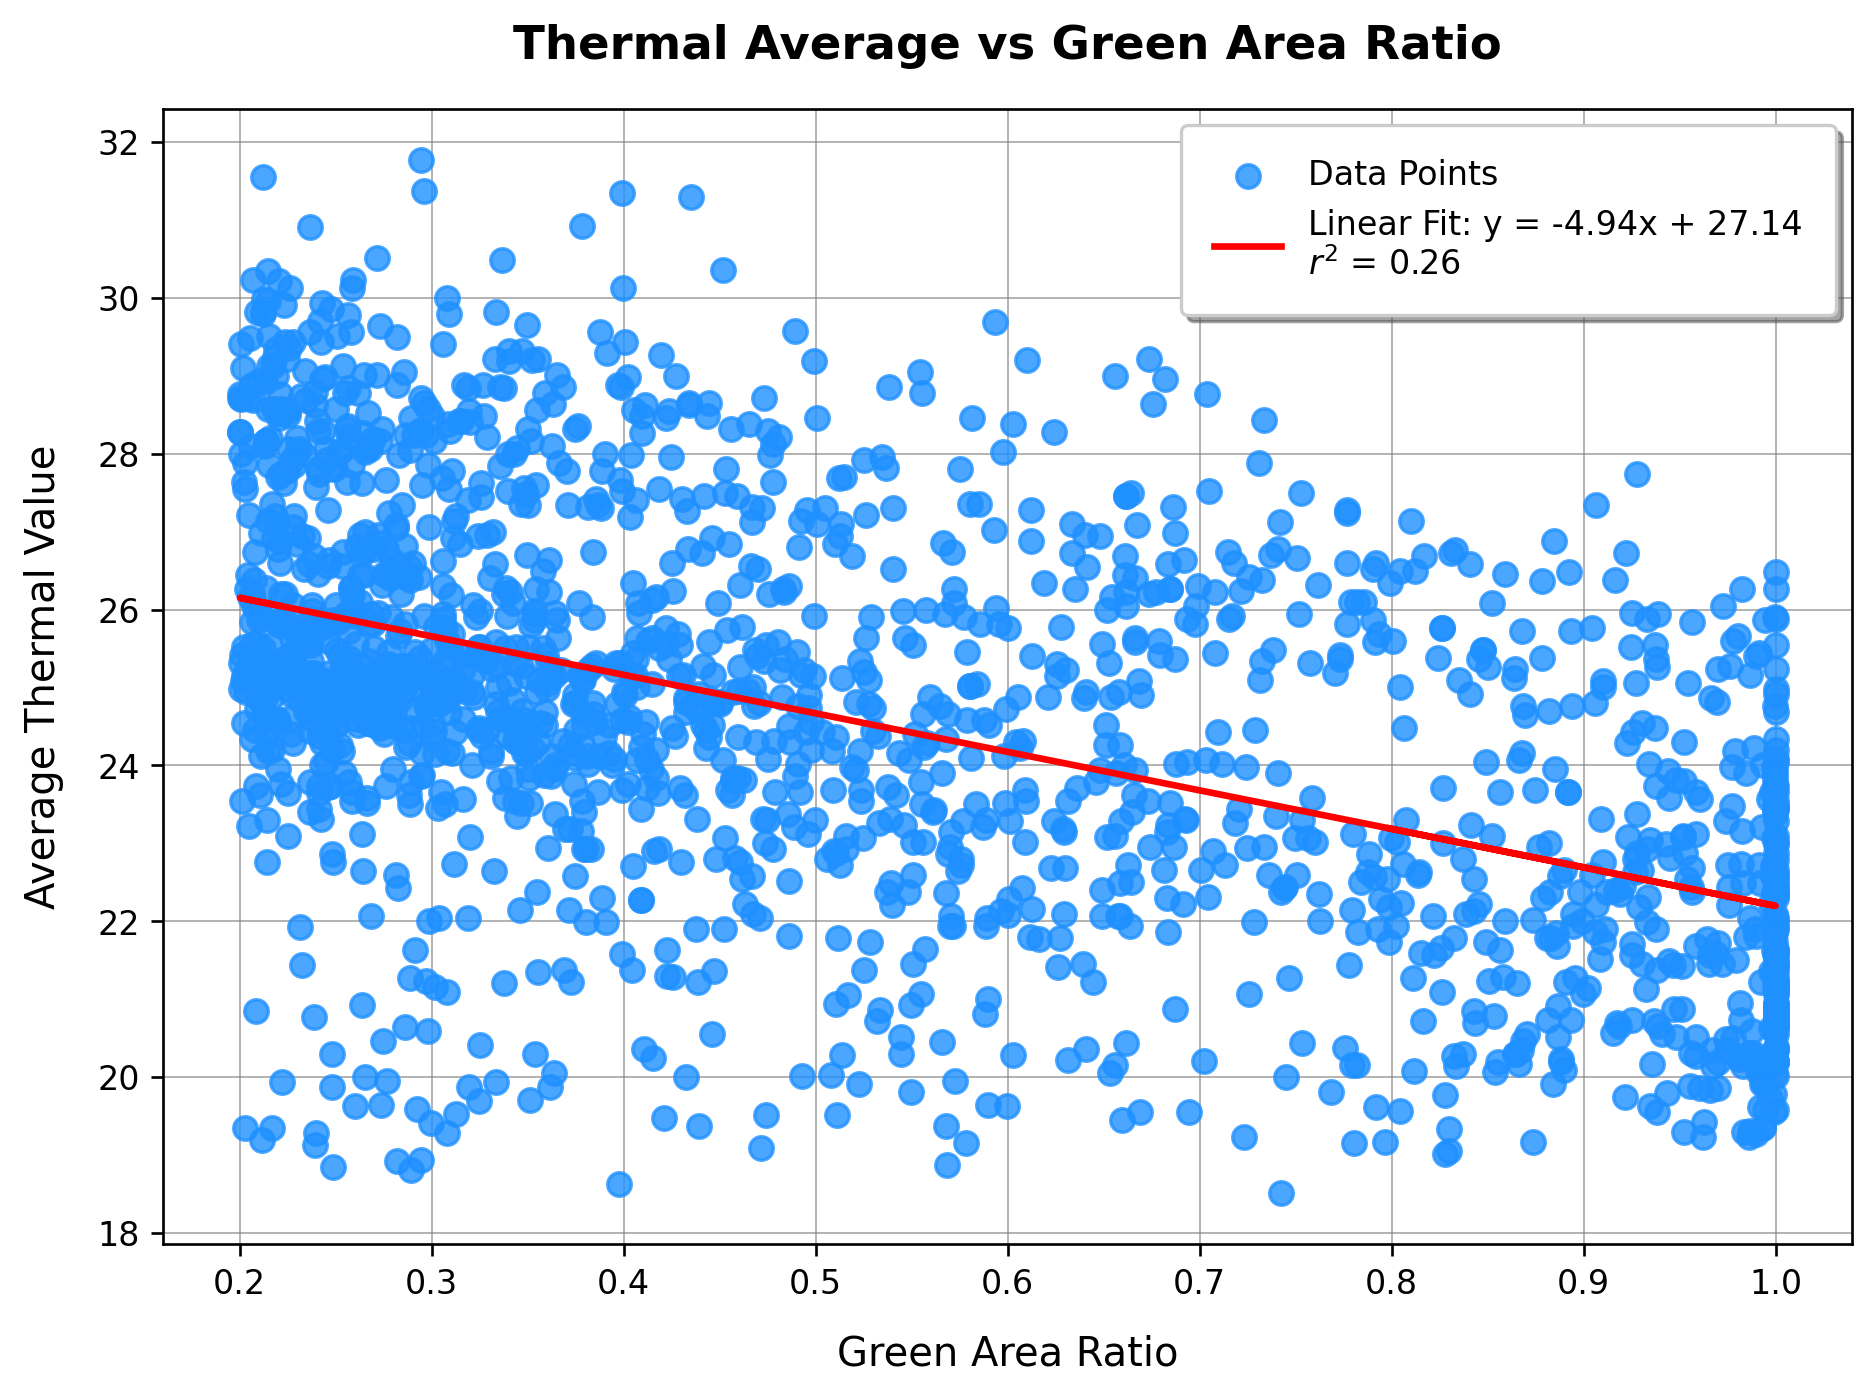

In [29]:
from sklearn.metrics import r2_score

plt.figure(figsize=(10, 6))

filtered_indices = np.array(green_ratios) >= 0.2

filtered_green_ratios = green_ratios[filtered_indices]
filtered_green_ratios = np.array(filtered_green_ratios, dtype=np.float64)

filtered_thermal_avg = thermal_avg[filtered_indices] / 100
filtered_thermal_avg = np.array(filtered_thermal_avg, dtype=np.float64)

# Perform linear regression
slope, intercept = np.polyfit(filtered_green_ratios, filtered_thermal_avg, 1)  # Linear fit
regression_line = slope * filtered_green_ratios + intercept  # Regression values

r2 = r2_score(filtered_thermal_avg, regression_line)

plt.figure(figsize=(8, 6), dpi=120)  

plt.scatter(filtered_green_ratios, filtered_thermal_avg, 
            color='dodgerblue', alpha=0.8, 
            label='Data Points', s=50)


plt.plot(filtered_green_ratios, regression_line, 
         color="red",linewidth=2, 
         label=f"Linear Fit: y = {slope:.2f}x + {intercept:.2f}\n$r^2$ = {r2:.2f}")

plt.title("Thermal Average vs Green Area Ratio", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Green Area Ratio", fontsize=12, labelpad=10)
plt.ylabel("Average Thermal Value", fontsize=12, labelpad=10)

plt.grid(color='gray', linewidth=0.5, alpha=0.7, zorder=0)
plt.gca().set_axisbelow(True) 

plt.legend(loc="upper right", fontsize=10, frameon=True, shadow=True, borderpad=1)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.show()

### Filter Weights

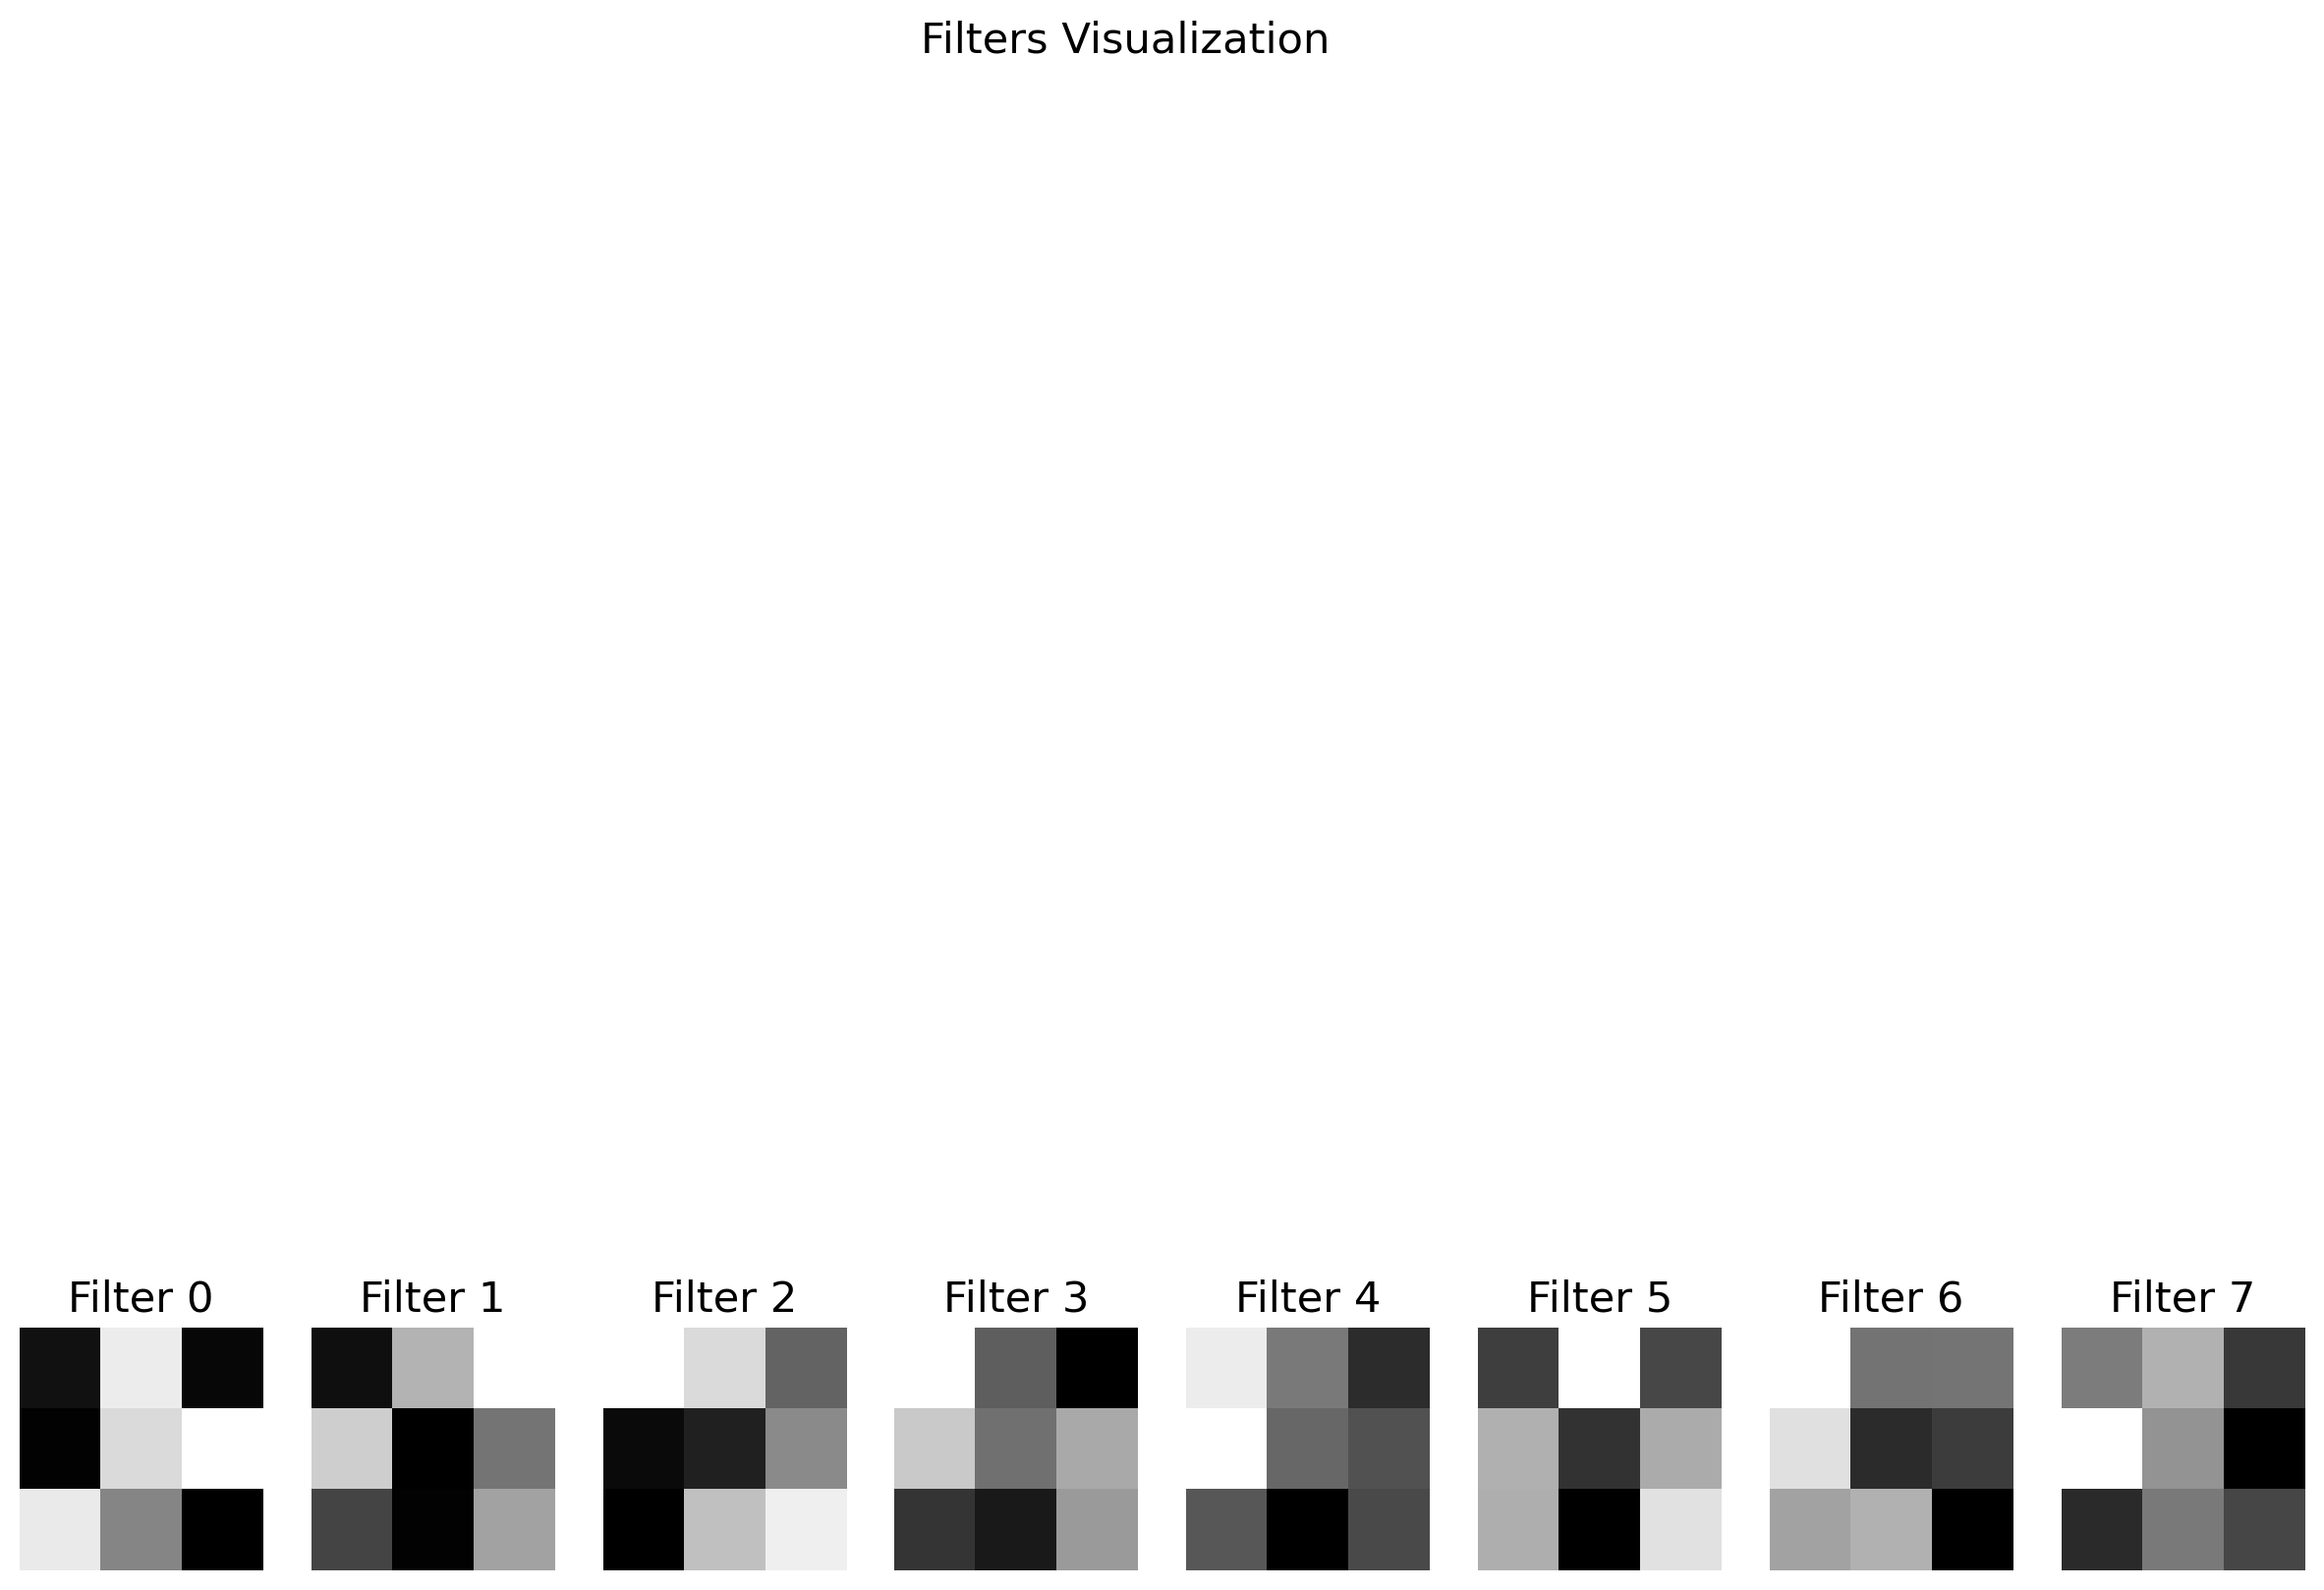

In [30]:
layer_weights = model.get_layer('conv2d').get_weights()[0]  # Replace 'conv2d' with your layer name

def visualize_filters(filters):
    num_filters = filters.shape[-1]  # Number of filters
    plt.figure(figsize=(15, 15))
    plt.suptitle("Filters Visualization")
    
    for i in range(min(8, num_filters)):  # Visualize up to 8 filters
        plt.subplot(1, min(8, num_filters), i + 1)
        plt.imshow(filters[:, :, 0, i], cmap='gray')  # Visualize filter weights
        plt.axis('off')
        plt.title(f"Filter {i}")
    plt.show()

visualize_filters(layer_weights)

In [31]:
#layer_weights.shape

In [32]:
# def compute_grad_cam(model, img_array, layer_name):
#     grad_model = Model(
#         inputs=[model.input],
#         outputs=[model.get_layer(layer_name).output, model.output]
#     )
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         loss = predictions[:, tf.argmax(predictions[0])]
#     grads = tape.gradient(loss, conv_outputs)
#     guided_grads = grads[0]
#     conv_outputs = conv_outputs[0]
#     weights = tf.reduce_mean(guided_grads, axis=(0, 1))
#     cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

#     for i, w in enumerate(weights):
#         cam += w * conv_outputs[:, :, i]
#     cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
#     return cam

# # Generate Grad-CAM for a single image
# layer_name = 'conv2d'  # Replace with the layer name for which you want Grad-CAM
# grad_cam = compute_grad_cam(model, sample_image, layer_name)

# # Plot Grad-CAM
# plt.imshow(grad_cam, cmap='jet', alpha=0.5)
# plt.title("Grad-CAM Visualization")
# plt.axis('off')
# plt.show()